# QF621 Quant Trading Strategy
## Group 5

    Yu Lingfeng
    Huang Wenying
    Liu Jing
    Wang Wenjie
    Li Lingwei

### 9 FOREX Pairs 
#### price data 1st retrived on `18th Apr 2024`
#### tickers used for `yfinance data` source
#### clean data cut-off from `2007-01-01`
#### strategy evaluating period from `2010-01-01` to `2020-01-01`
#### strategy testing period from `2020-01-01` to `2024-04-18`


In [1]:
## only run this when necessary
# !pip install pandas-datareader
# !pip install yfinance
# !pip install seaborn
# !pip install --upgrade pandas
# !pip install statsmodels
# !pip install ta
# !pip install mplcursors mpldatacursor


In [1]:
import numpy as np # for numerical computing
import pandas as pd # for tabular data manipulation
import matplotlib.pyplot as plt # for data graphics
import matplotlib.dates as mdates

import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.formula.api as smf
import pandas_datareader.data as web 
from pandas_datareader import data as pdr
%matplotlib inline
import statsmodels.api as sm
from scipy import stats
from ta.trend import IchimokuIndicator
import yfinance as yf
(
    yf
    .pdr_override()
)
import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")
import os
from scipy.interpolate import interp1d
import seaborn as sns
import os

from scipy.stats import norm
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from IPython.display import display
from IPython.display import Image

## <a id = "top">Table of Content</a>
### [0. Preprocessing data](#p0)
- ##### [1. FOREX data](#p001)
- ##### [2. Train Test Partition](#p002)

### [1. Strategy Listing](#p1)
- ##### [1.1 Max Return](#p11)
- ##### [1.2 Min Risk](#p12)
<!-- - ##### [1.3 Pairs](#p13) -->

### [2. Strategy Composition](#p2)
- ##### [2.1 Portfolio Strategy Loading](#p21)
- ##### [2.2 Strategy Weightage](#p22)
- ##### [2.2.1 Manual Selection of Portoflio Strategies](#p221)
- ##### [2.3 Final Portfolio - VaR 2 strike](#p23)
- ##### [2.4 Visulization](#p24)


In [2]:
pre = '2006-12-29'
start = '2010-01-01'
end = '2020-01-01'
post = '2024-03-01'

## <a id = "p0"> 0. </a> Preprocessing Data [back to table of contents](#top)

In [3]:
present =\
    datetime\
    .datetime\
    .today()\
    .strftime("%Y-%m-%d")
present

'2024-05-15'

In [5]:
def load_data(tickers, names, abbr):
    
    target_file_path =\
        '###'+ abbr + 'Data.csv'
    try:
        # Try to read the file
        target_data =\
            pd.read_csv(target_file_path,
                        header=[0, 1],
                        index_col=0)
        target_data.index =\
            pd.to_datetime(target_data.index)
    except FileNotFoundError:
        # If the file doesn't exist, download data
        target_data =\
            yf.download(tickers)
        target_data.columns =\
            pd.MultiIndex.from_product(
                [target_data.columns.levels[0],
                 [names[i] for i in\
                  [tickers.index(item) for item in\
                   list(target_data.columns.levels[1])]]])
        target_data.index =\
            pd.to_datetime(target_data.index)

        # Save the DataFrame to a CSV file
        target_data.to_csv(target_file_path, index = True)
     
    # Check if database update is needed
    last_update =\
        pd.to_datetime(target_data.index[-1])
    today = datetime.datetime.today()
    update_margin = 5
    if last_update < today:
        update_start =\
            target_data.index[-update_margin]   
        update_end =\
            today.strftime("%Y-%m-%d")
#         print(update_start)
#         print(update_end)        
        update_data =\
            yf.download(tickers,
                        start=update_start, 
                        end=update_end)
        update_data.columns =\
            pd.MultiIndex.from_product(
                [update_data.columns.levels[0],
                 [names[i] for i in\
                  [tickers.index(item) for item in\
                   list(update_data.columns.levels[1])]]])
        update_data.index =\
            pd.to_datetime(update_data.index)
        
        target_data =\
            pd.concat([target_data.iloc[:-update_margin],
                           update_data],
                      axis = 0)
        target_data = target_data.drop_duplicates(keep='last')
        # Save the DataFrame to a CSV file
        target_data.to_csv(target_file_path, index = True)        
        print(f"database updated on {update_end}")        
        
    target_price = target_data.loc[ : , ("Adj Close", names)]
    target_price.columns = target_price.columns.droplevel()

    return target_price

In [6]:
today = datetime.datetime.today()
print(today.strftime('%Y%m%d'))
print(today.strftime("%Y-%m-%d"))

today

20240508
2024-05-08


datetime.datetime(2024, 5, 8, 20, 24, 15, 576725)

##### <a id = "p001"> </a> 1. FX data [back to table of contents](#top)

In [7]:
# 1st retrieved on 18th Apr 2024 from yahoo finance

FX_tickers = ["USDJPY=X", "USDEUR=X", "USDGBP=X",\
              "USDAUD=X", "USDCAD=X", "USDCHF=X",\
              "USDNZD=X", "USDSGD=X", "USDZAR=X"]

FX_names = ["USDJPY", "USDEUR", "USDGBP",\
            "USDAUD", "USDCAD", "USDCHF",\
            "USDNZD", "USDSGD", "USDZAR"]

FX_price =\
    load_data(FX_tickers,
              FX_names, 
              'FX')
FX_price

[*********************100%%**********************]  9 of 9 completed
database updated on 2024-05-08


,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
1996-10-30,114.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-11-01,113.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-11-04,113.879997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-11-05,114.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-11-06,113.949997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-05-01,157.722000,0.93751,0.80063,1.543686,1.37770,0.91949,1.70082,1.36521,18.778099
2024-05-02,155.703995,0.93270,0.79749,1.530948,1.37230,0.91636,1.68631,1.35997,18.543699
2024-05-03,153.044998,0.93170,0.79741,1.521746,1.36662,0.90977,1.67676,1.35373,18.540480


* pre = `2006-12-29`
* start = `2010-01-01`
* end = `2020-01-01`
* post = `2024-02-29`

In [8]:
FX_price.loc[pre:post]

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2006-12-29,118.980003,0.75769,0.51041,1.267700,1.16470,1.21960,1.418400,1.53580,6.998800
2007-01-01,118.879997,0.75649,0.50911,1.264200,1.16430,1.21660,1.417200,1.53200,7.000000
2007-01-02,118.830002,0.75324,0.50674,1.256000,1.16480,1.21310,1.414800,1.53060,6.906700
2007-01-03,119.339996,0.75924,0.51224,1.262300,1.17260,1.22500,1.415600,1.53270,6.969800
2007-01-04,118.830002,0.76377,0.51467,1.276500,1.17760,1.23200,1.437200,1.53610,7.096300
...,...,...,...,...,...,...,...,...,...
2024-02-26,150.498001,0.92421,0.78910,1.523140,1.35072,0.88125,1.616320,1.34333,19.305799
2024-02-27,150.565994,0.92158,0.78836,1.529146,1.35013,0.87990,1.621510,1.34428,19.212601
2024-02-28,150.494995,0.92210,0.78854,1.528141,1.35317,0.87880,1.620670,1.34392,19.069401


In [9]:
FX_pool = FX_price.loc[pre:post]
print(FX_pool.isna().sum())
FX_pool = FX_pool.ffill()
print(FX_pool.isna().sum().sum())

USDJPY    17
USDEUR    17
USDGBP     5
USDAUD     2
USDCAD     2
USDCHF     4
USDNZD     1
USDSGD     1
USDZAR     3
dtype: int64
0


In [10]:
FX_pool.shape

(4471, 9)

In [11]:
FX_pool.head()

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2006-12-29,118.980003,0.75769,0.51041,1.2677,1.1647,1.2196,1.4184,1.5358,6.9988
2007-01-01,118.879997,0.75649,0.50911,1.2642,1.1643,1.2166,1.4172,1.5320,7.0000
2007-01-02,118.830002,0.75324,0.50674,1.2560,1.1648,1.2131,1.4148,1.5306,6.9067
2007-01-03,119.339996,0.75924,0.51224,1.2623,1.1726,1.2250,1.4156,1.5327,6.9698
2007-01-04,118.830002,0.76377,0.51467,1.2765,1.1776,1.2320,1.4372,1.5361,7.0963


In [12]:
FX_pool.tail()

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2024-02-26,150.498001,0.92421,0.78910,1.523140,1.35072,0.88125,1.616320,1.34333,19.305799
2024-02-27,150.565994,0.92158,0.78836,1.529146,1.35013,0.87990,1.621510,1.34428,19.212601
2024-02-28,150.494995,0.92210,0.78854,1.528141,1.35317,0.87880,1.620670,1.34392,19.069401
2024-02-29,150.656006,0.92261,0.78970,1.539717,1.35775,0.87871,1.640124,1.34596,19.253099
2024-03-01,150.095001,0.92550,0.79205,1.538840,1.35737,0.88440,1.643170,1.34592,19.180420


##### <a id = "p002"> </a> 2. Train Test partition [back to table of contents](#top)

In [13]:
FX_train =\
    FX_pool.loc[:end]
if end in FX_train.index:
    FX_train = FX_train[:-1]
FX_train.tail()

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2019-12-25,109.383003,0.901700,0.77310,1.444700,1.31640,0.98030,1.505344,1.35500,14.14951
2019-12-26,109.369003,0.901270,0.77080,1.444100,1.31550,0.97940,1.504438,1.35472,14.15085
2019-12-27,109.542000,0.900810,0.76910,1.439600,1.31080,0.98147,1.498640,1.35340,14.13117
2019-12-30,109.428001,0.894270,0.76383,1.432050,1.30734,0.97371,1.491110,1.35213,14.05089
2019-12-31,108.873001,0.892674,0.76260,1.428286,1.30606,0.96863,1.484830,1.34818,14.09859


In [14]:
FX_train.index

DatetimeIndex(['2006-12-29', '2007-01-01', '2007-01-02', '2007-01-03',
               '2007-01-04', '2007-01-05', '2007-01-08', '2007-01-09',
               '2007-01-10', '2007-01-11',
               ...
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=3383, freq=None)

In [15]:
FX_test =\
    FX_pool.loc[end:]
FX_test.head()

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2020-01-01,108.681000,0.891200,0.75400,1.42511,1.30020,0.96720,1.473666,1.33450,13.99590
2020-01-02,108.712997,0.891200,0.75470,1.42460,1.29730,0.96750,1.484300,1.34519,14.00292
2020-01-03,108.542999,0.895140,0.76030,1.43160,1.29830,0.97120,1.492490,1.34690,14.07800
2020-01-06,107.963997,0.895900,0.76452,1.44005,1.29866,0.97148,1.502560,1.34978,14.31825
2020-01-07,108.405998,0.893017,0.75930,1.44148,1.29639,0.96850,1.499360,1.34917,14.20270


## <a id = "p1"> 1. </a> Strategy Listing [back to table of contents](#top)

In [16]:
def gen_date_tag(start_date, end_date, m,
                 pre_start=12, pre_end=2, form='%Y-%m-%d'):
    date_tags = []
    train_start = []
    train_end = []
    # Convert the input string to a datetime object
    input_date = datetime.datetime.strptime(start_date, form)
    
    while input_date < datetime.datetime.strptime(end_date, form):
        # Format the result date as a string in 'YYYY-MM-DD' format
        date_tags.append(input_date.strftime(form))
        train_s =\
            input_date - relativedelta(months=pre_start)
        train_start.append(train_s.strftime(form))
        train_e =\
            input_date - relativedelta(months=pre_end)
        train_end.append(train_e.strftime(form))
        # Move to the next date `m` months later
        input_date += relativedelta(months=m)
    date_tags.append(end_date)
    return date_tags, train_start, train_end

In [17]:
test_date_tag, train_start_tag, train_end_tag =\
    gen_date_tag(start, end, 12)

print(test_date_tag)
print(train_start_tag)
print(train_end_tag)

['2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
['2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']
['2009-11-01', '2010-11-01', '2011-11-01', '2012-11-01', '2013-11-01', '2014-11-01', '2015-11-01', '2016-11-01', '2017-11-01', '2018-11-01']


In [4]:
def VaR_para(SR, var=0.01):
    m = SR.mean()
    std = SR.std()
    
    VaR1d =\
        (m + std * norm.ppf(var))
    
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

def VaR_hist(SR, var=0.01):
    SR =\
        SR\
        .sort_values()\
        .reset_index(drop=True)
    idx =\
        var *\
        len(SR) - 1
    lower = int(idx)
    upper = lower + 1
        
    VaR1d =\
        SR[lower] +\
        (SR[upper] - SR[lower]) *\
        (idx - lower) * 1
    if VaR1d > 0:
        VaR1d = 0    
    return abs(VaR1d)

##### <a id = "p11"> </a> 1.1 Max Return Portfolio [back to table of contents](#top)

In [19]:
def Max_Ret_w(pool_prices, bounds = Bounds(-1,1)):
    
    '''
    Using `minimize` function for solution solving

    * function: calculate annualized risk from normal daily return
    * initial guess: equal weight (or other guess vector)
    * method: `trust-constr`
    * linear_constraint
    * bounds

    -> solve for result

    '''
    pool_df =\
        pool_prices.pct_change()
    pool_df = pool_df.dropna()
    r = np.mean(pool_df,axis=0)*252     
    cov = pool_df.cov()
    port_stderr = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)
    invSharpe = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)/(r@w)    
    w = np.ones(pool_prices.shape[1])
    x0 = w/np.sum(w) 
    
    linear_constraint =\
        LinearConstraint(np.ones((pool_df.shape[1],),dtype=int),1,1)    
    
    result_max =\
        minimize(invSharpe,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)  
    
    w_max = result_max.x 
    Return_max = r@w_max
    Risk_max = port_stderr(w_max)    
    
    return [w_max, Return_max, Risk_max]

In [20]:
Max_test =\
   Max_Ret_w(FX_pool.loc[start:end], Bounds(-1,1)) 
print("weightage by max return portfolio is: ", Max_test[0])
print("Sum of total weightages: ", Max_test[0].sum())
print("expected annualize max return portfolio return is: ", Max_test[1])
print("expected annualize max return portfolio volatility is: ", Max_test[2])

weightage by max return portfolio is:  [ 0.69368603  0.65217253  0.29033132  0.39388084  0.52587344 -0.43741012
 -0.64001579 -0.9999981   0.52147984]
Sum of total weightages:  1.0000000000000016
expected annualize max return portfolio return is:  0.09663135074917178
expected annualize max return portfolio volatility is:  0.11928509832745186


In [21]:
def Max_Ret(pool_prices, start_date, end_date, m, 
            bounds = Bounds(-1,1), pre_start=12, pre_end=2, 
            form='%Y-%m-%d', name='Strategy'):
    strategy =\
        pd.DataFrame(index=pool_prices.loc[start_date:end_date].index,
                     columns=list(pool_prices.columns))
    
    pool_pct =\
        pool_prices\
        .pct_change()
    
    test_date, train_start, train_end =\
        gen_date_tag(start_date, end_date, m, pre_start, pre_end, form)    

    for i in range(len(train_start)):
        
        temp_w =\
           Max_Ret_w(pool_prices\
                         .loc[train_start[i]:train_end[i]],
                     bounds) 
        
        strategy.loc[test_date[i]:test_date[i+1]] =\
            temp_w[0]

    if start_date in strategy.index:
        strategy = strategy[:-1]

    pnl =\
        (strategy * pool_pct.loc[start_date:end_date])\
        .dropna()\
        .sum(axis=1)
    pnl.name =\
        name + ' PnL'

    strategy =\
        pd.concat([pd.DataFrame(pnl), strategy], axis = 1)
    return strategy

In [22]:
FX_max =\
    Max_Ret(FX_pool, start, end, 12, name='Max Return')
FX_max

,Max Return PnL,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,,
2010-01-01,-0.000465,0.152778,0.284752,0.18722,-0.160283,0.068599,0.376805,-0.022131,0.172204,-0.059943
2010-01-04,-0.000952,0.152778,0.284752,0.18722,-0.160283,0.068599,0.376805,-0.022131,0.172204,-0.059943
2010-01-05,0.002212,0.152778,0.284752,0.18722,-0.160283,0.068599,0.376805,-0.022131,0.172204,-0.059943
2010-01-06,-0.00138,0.152778,0.284752,0.18722,-0.160283,0.068599,0.376805,-0.022131,0.172204,-0.059943
2010-01-07,0.00569,0.152778,0.284752,0.18722,-0.160283,0.068599,0.376805,-0.022131,0.172204,-0.059943
...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.002283,-0.192572,-0.180766,0.412581,0.999998,-0.408326,0.503335,0.313215,-0.999991,0.552526
2019-12-26,-0.001644,-0.192572,-0.180766,0.412581,0.999998,-0.408326,0.503335,0.313215,-0.999991,0.552526
2019-12-27,-0.002717,-0.192572,-0.180766,0.412581,0.999998,-0.408326,0.503335,0.313215,-0.999991,0.552526


In [5]:
def pnlPerformance(pnl, label):
    
    metrics = []
    metrics_KPI = []
    cumpnl = pnl.cumsum(skipna = True)
    import matplotlib.pyplot as plt
    import numpy as np
    sharpe = pnl.mean()/np.std(pnl)
    sharpe = sharpe*np.sqrt(252)
    
    metrics += [float(sharpe)]
    metrics += [float(pnl.mean()*252*100)]  
    metrics += [float(pnl.sum()*100)]
    

    highwatermark_df = cumpnl.cummax();
    drawdown_df = cumpnl - highwatermark_df;
    maxdrawdown = drawdown_df.min();
    
    metrics += [float(maxdrawdown*100)]       
    
    metrics += [VaR_para(pnl.iloc[:,0], 0.01)*100]   
    metrics += [VaR_hist(pnl.iloc[:,0], 0.01)*100]
    metrics += [VaR_para(pnl.iloc[:,0], 0.05)*100]   
    metrics += [VaR_hist(pnl.iloc[:,0], 0.05)*100]    
        
    plt.plot(cumpnl, label = label);    
    plt.legend();
    plt.title("Cumulative PNL chart for " + label)
    plt.show();
    
    #HERE, we compute performance during 'stressed' historical periods
    stressedmarkets = dict()
    
    stressedmarkets["Covid19"] = ('2020-03-01', '2020-03-17');          #Market crash 1H March 2020
    stressedmarkets["Dec18"] = ('2018-12-15', '2018-12-31');            #Market crash last 2 weeks
    stressedmarkets["Fall2015"] = ('2015-07-01', '2015-09-01');         #Taper tantrum / EU debt crisis.  24 Aug 2015 was "BlackMonday" for Asian, EU and US markets
    stressedmarkets["Oct14"] = ('2014-10-01', '2014-10-31');            #Treasury flash crash on 15 Oct 2014
    stressedmarkets["Aug2013"] = ('2013-08-20', '2013-08-25');          #Flash freeze on 22 Aug 2013        
    
    for tkey in stressedmarkets.keys():
        mask = pnl.index.to_series().between(stressedmarkets[tkey][0], stressedmarkets[tkey][1])
        metrics += [float(pnl[mask].sum()*100)]
        metrics_KPI += ["Stressed %return during "+ str(tkey)]
    
    print("===========================")

    metrics =\
        pd.DataFrame(
            {f"{label} PERFORMANCE": metrics}
        )
    metrics.index =\
    [
        'Daily annualized sharpe',
        'Average annual returns %',
        'Total returns %',
        'Max drawdown %',    
        '%VaR1d 1% - para',
        '%VaR1d 1% - hist',
        '%VaR1d 5% - para',
        '%VaR1d 5% - hist',
        
    ] + metrics_KPI
    
    return metrics

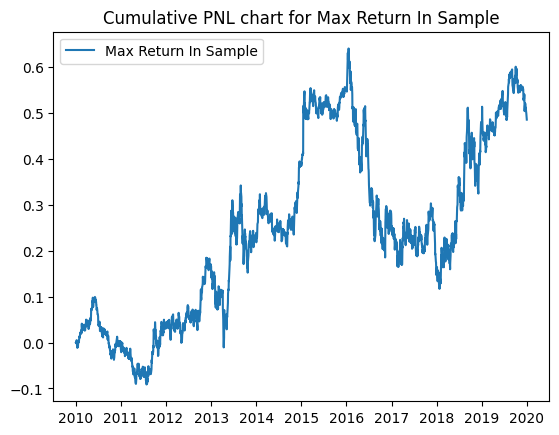

,Max Return In Sample PERFORMANCE
Daily annualized sharpe,0.286675
Average annual returns %,4.701885
Total returns %,48.586149
Max drawdown %,-52.412033
%VaR1d 1% - para,2.385373
%VaR1d 1% - hist,2.552929
%VaR1d 5% - para,1.681122
%VaR1d 5% - hist,1.603215
Stressed %return during Covid19,0.000000
Stressed %return during Dec18,8.852464


In [24]:
FX_max_IS =\
    pnlPerformance(FX_max[['Max Return PnL']], 'Max Return In Sample')
FX_max_IS

In [25]:
ylf1 =\
    Max_Ret(FX_pool, start, post, 7, pre_start=11, pre_end=3, name='Max Return')
ylf1.to_csv('ylf1.csv')
ylf1

,Max Return PnL,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,,
2010-01-01,-0.000002,-0.037648,0.396246,0.388466,-0.255267,0.16445,0.791584,-0.174002,-0.114756,-0.159075
2010-01-04,0.002798,-0.037648,0.396246,0.388466,-0.255267,0.16445,0.791584,-0.174002,-0.114756,-0.159075
2010-01-05,0.007176,-0.037648,0.396246,0.388466,-0.255267,0.16445,0.791584,-0.174002,-0.114756,-0.159075
2010-01-06,-0.004365,-0.037648,0.396246,0.388466,-0.255267,0.16445,0.791584,-0.174002,-0.114756,-0.159075
2010-01-07,0.004103,-0.037648,0.396246,0.388466,-0.255267,0.16445,0.791584,-0.174002,-0.114756,-0.159075
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,0.001078,0.992266,0.662967,-0.83971,0.748796,-0.168729,-0.999995,-0.366072,0.942154,0.028323
2024-02-26,-0.001018,0.992266,0.662967,-0.83971,0.748796,-0.168729,-0.999995,-0.366072,0.942154,0.028323
2024-02-27,0.003262,0.992266,0.662967,-0.83971,0.748796,-0.168729,-0.999995,-0.366072,0.942154,0.028323


##### <a id = "p12"> </a> 1.2 Min Volitality Portfolio [back to table of contents](#top)

In [26]:
def Min_Vol_w(pool_prices, bounds = Bounds(-1,1)):
    
    '''
    Using `minimize` function for solution solving

    * function: calculate annualized risk from normal daily return
    * initial guess: equal weight (or other guess vector)
    * method: `trust-constr`
    * linear_constraint
    * bounds

    -> solve for result

    '''
    pool_df =\
        pool_prices.pct_change()
    pool_df = pool_df.dropna()
    r = np.mean(pool_df,axis=0)*252     
    cov = pool_df.cov()
    port_stderr = lambda w:np.sqrt(np.dot(w,np.dot(w,cov))*252)  
    w = np.ones(pool_prices.shape[1])
    x0 = w/np.sum(w) 
    
    linear_constraint =\
        LinearConstraint(np.ones((pool_df.shape[1],),dtype=int),1,1)      
    
    result_min =\
        minimize(port_stderr,
                 x0,
                 method="trust-constr",
                 constraints=linear_constraint,
                 bounds=bounds)    
    w_min = result_min.x

    Return_min = r@w_min
    Risk_min = port_stderr(w_min)
    
    return [w_min, Return_min, Risk_min]

In [27]:
Min_test =\
   Min_Vol_w(FX_pool.loc[start:end], Bounds(-1,1)) 
print("weightage by max return portfolio is: ", Min_test[0])
print("Sum of total weightages: ", Min_test[0].sum())
print("expected annualize max return portfolio return is: ", Min_test[1])
print("expected annualize max return portfolio volatility is: ", Min_test[2])

weightage by max return portfolio is:  [ 0.15616258 -0.08283126  0.11031122 -0.13078713  0.22993576  0.00939583
 -0.10344498  0.90174703 -0.09048904]
Sum of total weightages:  0.9999999999999999
expected annualize max return portfolio return is:  -0.006243230661505464
expected annualize max return portfolio volatility is:  0.04509118554264119


In [28]:
def Min_Vol(pool_prices, start_date, end_date, m, 
            bounds = Bounds(-1,1), pre_start=12, pre_end=2, 
            form='%Y-%m-%d', name='Strategy'):
    strategy =\
        pd.DataFrame(index=pool_prices.loc[start_date:end_date].index,
                     columns=list(pool_prices.columns))
    
    pool_pct =\
        pool_prices\
        .pct_change()
    
    test_date, train_start, train_end =\
        gen_date_tag(start_date, end_date, m, pre_start, pre_end, form)    

    for i in range(len(train_start)):
        
        temp_w =\
           Min_Vol_w(pool_prices\
                         .loc[train_start[i]:train_end[i]],
                     bounds) 
        
        strategy.loc[test_date[i]:test_date[i+1]] =\
            temp_w[0]

    if start_date in strategy.index:
        strategy = strategy[:-1]

    pnl =\
        (strategy * pool_pct.loc[start_date:end_date])\
        .dropna()\
        .sum(axis=1)
    pnl.name =\
        name + ' PnL'

    strategy =\
        pd.concat([pd.DataFrame(pnl), strategy], axis = 1)
    return strategy

In [29]:
FX_min =\
    Min_Vol(FX_pool, start, end, 12, name='Min Vol')
FX_min

,Min Vol PnL,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,,
2010-01-01,0.000191,0.161862,-0.113618,0.042093,-0.051809,0.106509,-0.015175,-0.085849,0.999977,-0.043989
2010-01-04,-0.003418,0.161862,-0.113618,0.042093,-0.051809,0.106509,-0.015175,-0.085849,0.999977,-0.043989
2010-01-05,-0.002404,0.161862,-0.113618,0.042093,-0.051809,0.106509,-0.015175,-0.085849,0.999977,-0.043989
2010-01-06,-0.000643,0.161862,-0.113618,0.042093,-0.051809,0.106509,-0.015175,-0.085849,0.999977,-0.043989
2010-01-07,0.00293,0.161862,-0.113618,0.042093,-0.051809,0.106509,-0.015175,-0.085849,0.999977,-0.043989
...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.000088,0.138245,-0.215749,0.06843,-0.199782,0.216157,0.110714,-0.055277,0.999977,-0.062715
2019-12-26,-0.000464,0.138245,-0.215749,0.06843,-0.199782,0.216157,0.110714,-0.055277,0.999977,-0.062715
2019-12-27,-0.000412,0.138245,-0.215749,0.06843,-0.199782,0.216157,0.110714,-0.055277,0.999977,-0.062715


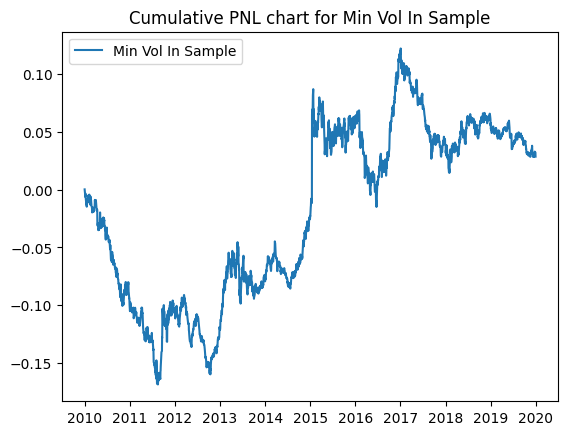

,Min Vol In Sample PERFORMANCE
Daily annualized sharpe,0.049276
Average annual returns %,0.275878
Total returns %,2.850744
Max drawdown %,-16.864363
%VaR1d 1% - para,0.819529
%VaR1d 1% - hist,0.899802
%VaR1d 5% - para,0.579131
%VaR1d 5% - hist,0.513133
Stressed %return during Covid19,0.000000
Stressed %return during Dec18,0.102675


In [30]:
FX_min_IS =\
    pnlPerformance(FX_min[['Min Vol PnL']], 'Min Vol In Sample')
FX_min_IS

In [31]:
ylf2 =\
    Min_Vol(FX_pool, start, post, 9, 
            pre_start=6, pre_end=2, name='Min Vol')
ylf2.to_csv('ylf2.csv')
ylf2

,Min Vol PnL,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,,
2010-01-01,-0.001518,0.150412,0.312479,-0.013378,-0.1085,0.030058,-0.247106,-0.065029,0.999994,-0.05893
2010-01-04,-0.001871,0.150412,0.312479,-0.013378,-0.1085,0.030058,-0.247106,-0.065029,0.999994,-0.05893
2010-01-05,-0.002029,0.150412,0.312479,-0.013378,-0.1085,0.030058,-0.247106,-0.065029,0.999994,-0.05893
2010-01-06,0.000589,0.150412,0.312479,-0.013378,-0.1085,0.030058,-0.247106,-0.065029,0.999994,-0.05893
2010-01-07,0.003273,0.150412,0.312479,-0.013378,-0.1085,0.030058,-0.247106,-0.065029,0.999994,-0.05893
...,...,...,...,...,...,...,...,...,...,...
2024-02-23,-0.001415,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799
2024-02-26,0.002,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799
2024-02-27,-0.001158,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799


## <a id = "p2"> 2. </a> Strategy Composition [back to table of contents](#top)

strategy names coded as:
* `strategy1_llw.csv`
* `strategy2_llw.csv`
* `ylf1.csv`
* `ylf2.csv`

In [32]:
FX_max_IS

,Max Return In Sample PERFORMANCE
Daily annualized sharpe,0.286675
Average annual returns %,4.701885
Total returns %,48.586149
Max drawdown %,-52.412033
%VaR1d 1% - para,2.385373
%VaR1d 1% - hist,2.552929
%VaR1d 5% - para,1.681122
%VaR1d 5% - hist,1.603215
Stressed %return during Covid19,0.000000
Stressed %return during Dec18,8.852464


##### <a id = "p21"> </a> 2.1 Portfolio Strategy Loading [back to table of contents](#top)

25


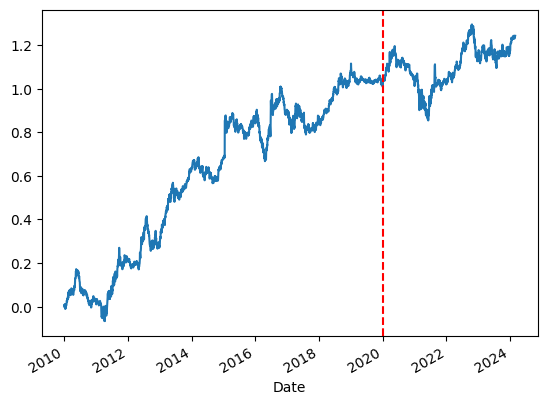

In [6]:
ylf1 =\
    pd.read_csv('ylf1.csv', index_col=0)
ylf1 =\
    ylf1.rename(columns={'Max Return PnL': 'ylf_1'})
ylf1.index = pd.to_datetime(ylf1.index)
ylf1_sig_date=\
    list(ylf1.index[(ylf1.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf1.loc[ylf1_sig_date[0]]) == 0:
    ylf1_sig_date = ylf1_sig_date[1:]
print(len(ylf1_sig_date))
ylf1.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

19


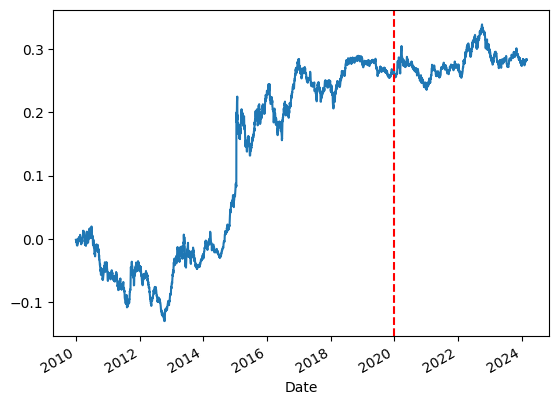

In [7]:
ylf2 =\
    pd.read_csv('ylf2.csv', index_col=0)
ylf2 =\
    ylf2.rename(columns={'Min Vol PnL': 'ylf_2'})
ylf2.index = pd.to_datetime(ylf2.index)
ylf2_sig_date=\
    list(ylf2.index[(ylf2.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf2.loc[ylf2_sig_date[0]]) == 0:
    ylf2_sig_date = ylf2_sig_date[1:]
print(len(ylf2_sig_date))
ylf2.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

79


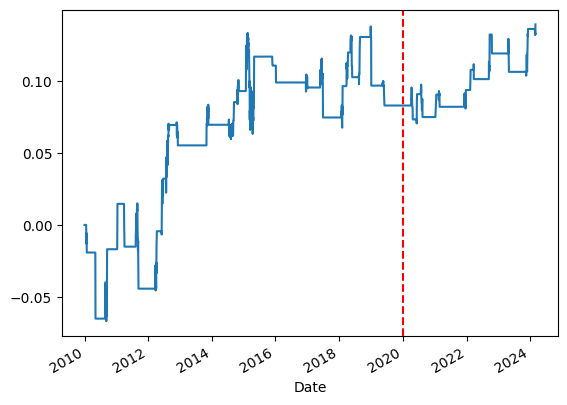

In [8]:
ylf3 =\
    pd.read_csv('ylf3.csv', index_col=0)
ylf3 =\
    ylf3.rename(columns={'Pair1 PnL': 'ylf_3'})
ylf3.index = pd.to_datetime(ylf3.index)
ylf3_sig_date=\
    list(ylf3.index[(ylf3.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf3.loc[ylf3_sig_date[0]]) == 0:
    ylf3_sig_date = ylf3_sig_date[1:]
print(len(ylf3_sig_date))
ylf3.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

157


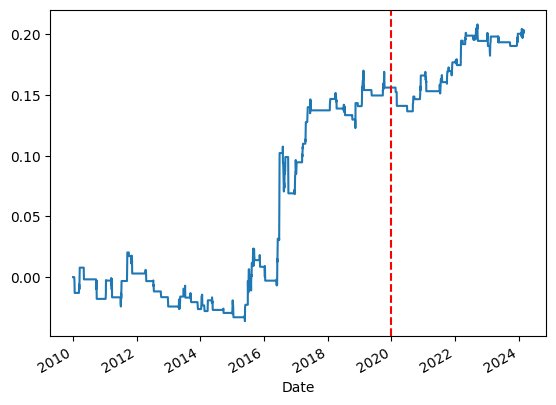

In [9]:
ylf4 =\
    pd.read_csv('ylf4.csv', index_col=0)
ylf4 =\
    ylf4.rename(columns={'Pair2 PnL': 'ylf_4'})
ylf4.index = pd.to_datetime(ylf4.index)
ylf4_sig_date=\
    list(ylf4.index[(ylf4.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf4.loc[ylf4_sig_date[0]]) == 0:
    ylf4_sig_date = ylf4_sig_date[1:]
print(len(ylf4_sig_date))
ylf4.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

79


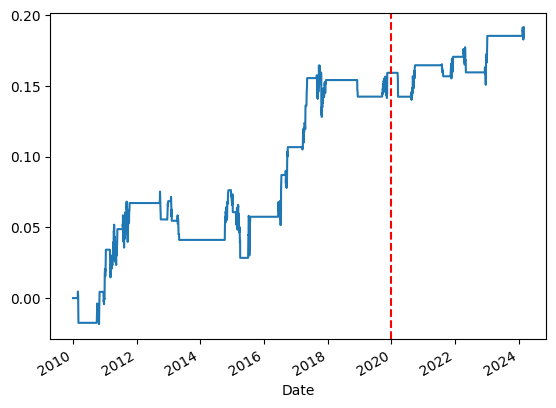

In [10]:
ylf5 =\
    pd.read_csv('ylf5.csv', index_col=0)
ylf5 =\
    ylf5.rename(columns={'Pair3 PnL': 'ylf_5'})
ylf5.index = pd.to_datetime(ylf5.index)
ylf5_sig_date=\
    list(ylf5.index[(ylf5.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf5.loc[ylf5_sig_date[0]]) == 0:
    ylf5_sig_date = ylf5_sig_date[1:]
print(len(ylf3_sig_date))
ylf5.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

79


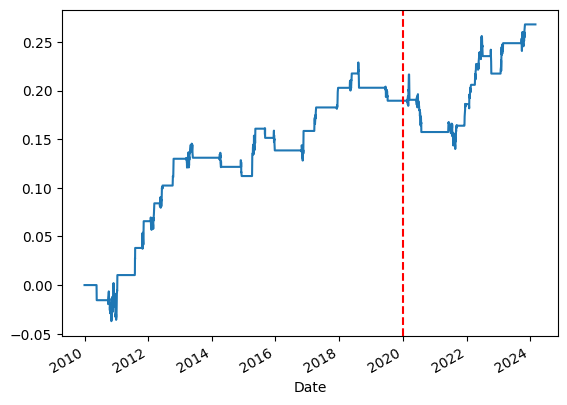

In [11]:
ylf6 =\
    pd.read_csv('ylf6.csv', index_col=0)
ylf6 =\
    ylf6.rename(columns={'Pair4 PnL': 'ylf_6'})
ylf6.index = pd.to_datetime(ylf6.index)
ylf6_sig_date=\
    list(ylf3.index[(ylf6.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(ylf6.loc[ylf6_sig_date[0]]) == 0:
    ylf6_sig_date = ylf6_sig_date[1:]
print(len(ylf3_sig_date))
ylf6.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

26


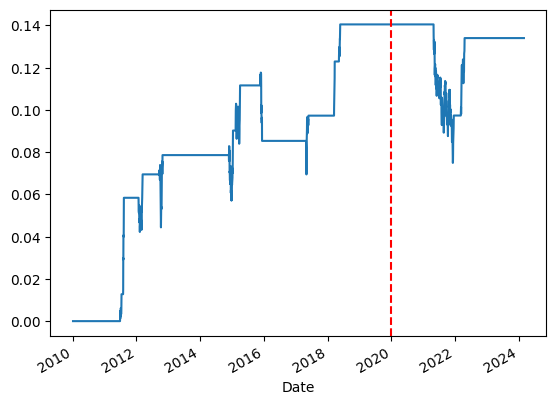

In [12]:
llw1 =\
    pd.read_csv('llw1.csv', index_col=0)
llw1 =\
    llw1.rename(columns={'daily_return': 'llw_1'})
llw1.index = pd.to_datetime(llw1.index)
llw1_sig_date=\
    list(llw1.index[(llw1.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(llw1.loc[llw1_sig_date[0]]) == 0:
    llw1_sig_date = llw1_sig_date[1:]
print(len(llw1_sig_date))
llw1.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

42


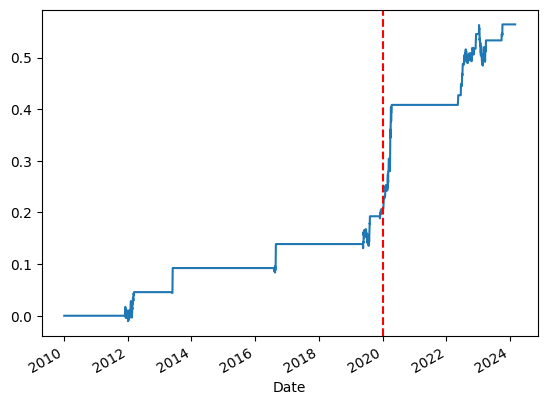

In [13]:
llw2 =\
    pd.read_csv('llw2.csv', index_col=0)
llw2 =\
    llw2.rename(columns={'daily_return': 'llw_2'})
llw2.index = pd.to_datetime(llw2.index)
llw2_sig_date=\
    list(llw2.index[(llw2.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(llw2.loc[llw2_sig_date[0]]) == 0:
    llw2_sig_date = llw2_sig_date[1:]
print(len(llw2_sig_date))
llw2.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

12


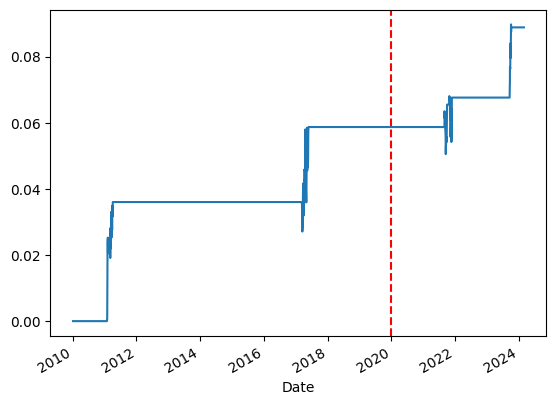

In [14]:
llw3 =\
    pd.read_csv('llw3.csv', index_col=0)
llw3 =\
    llw3.rename(columns={'daily_return': 'llw_3'})
llw3.index = pd.to_datetime(llw3.index)
llw3_sig_date=\
    list(llw3.index[(llw3.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(llw3.loc[llw3_sig_date[0]]) == 0:
    llw3_sig_date = llw3_sig_date[1:]
print(len(llw3_sig_date))
llw3.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

40


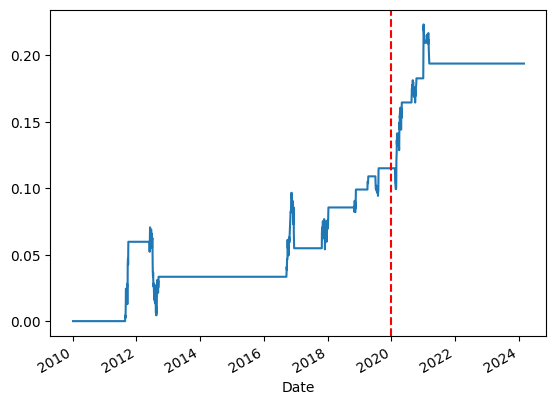

In [15]:
llw4 =\
    pd.read_csv('llw4.csv', index_col=0)
llw4 =\
    llw4.rename(columns={'daily_return': 'llw_4'})
llw4.index = pd.to_datetime(llw4.index)
llw4_sig_date=\
    list(llw4.index[(llw4.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(llw4.loc[llw4_sig_date[0]]) == 0:
    llw4_sig_date = llw4_sig_date[1:]
print(len(llw4_sig_date))
llw4.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

44


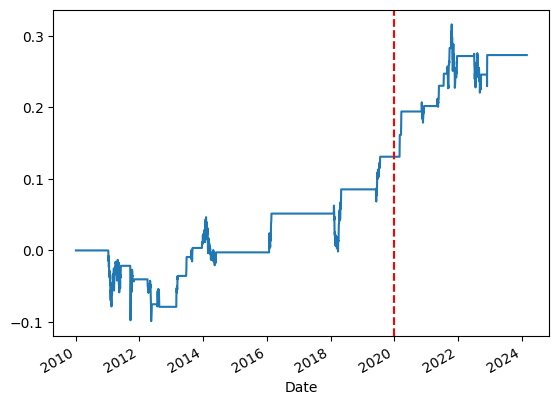

In [16]:
llw5 =\
    pd.read_csv('llw5.csv', index_col=0)
llw5 =\
    llw5.rename(columns={'daily_return': 'llw_5'})
llw5.index = pd.to_datetime(llw5.index)
llw5_sig_date=\
    list(llw5.index[(llw5.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(llw5.loc[llw5_sig_date[0]]) == 0:
    llw5_sig_date = llw5_sig_date[1:]
print(len(llw5_sig_date))
llw5.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

372


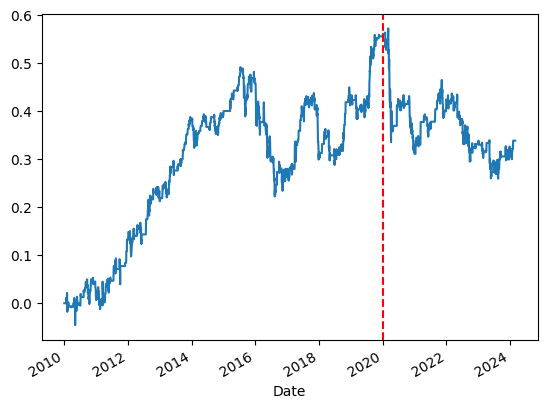

In [17]:
hwy1 =\
    pd.read_csv('hwy1.csv', index_col=0)
hwy1 =\
    hwy1.rename(columns={'daily_return': 'hwy_1'})
hwy1.index = pd.to_datetime(hwy1.index)
hwy1_sig_date=\
    list(hwy1.index[(hwy1.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(hwy1.loc[hwy1_sig_date[0]]) == 0:
    hwy1_sig_date = hwy1_sig_date[1:]
print(len(hwy1_sig_date))
hwy1.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

102


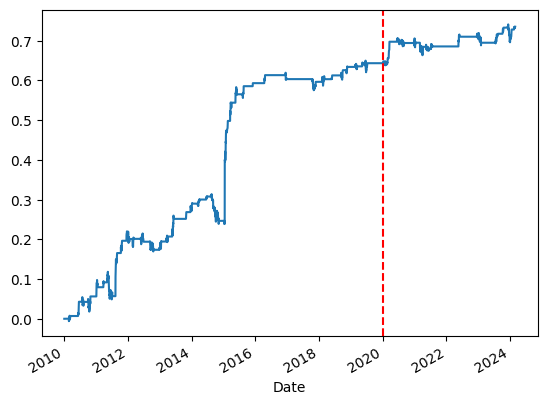

In [18]:
hwy2 =\
    pd.read_csv('hwy2.csv', index_col=0)
hwy2 =\
    hwy2.rename(columns={'daily_return': 'hwy_2'})
hwy2.index = pd.to_datetime(hwy2.index)
hwy2_sig_date=\
    list(hwy2.index[(hwy2.iloc[:,1:].diff()!=0).any(axis=1)])
if sum(hwy2.loc[hwy2_sig_date[0]]) == 0:
    hwy2_sig_date = hwy2_sig_date[1:]
print(len(hwy2_sig_date))
hwy2.iloc[:,0].cumsum().plot()
plt.axvline(x=end, color='r', linestyle='--')

In [19]:
sig_dates =\
{
    0: ylf1_sig_date,
    1: ylf2_sig_date,
    2: ylf3_sig_date,
    3: ylf4_sig_date,  
    4: ylf5_sig_date,
    5: ylf6_sig_date, 
    6: llw1_sig_date,
    7: llw2_sig_date,
    8: llw3_sig_date,
    9: llw4_sig_date,
    10: llw5_sig_date,
    11: hwy1_sig_date,
    12: hwy2_sig_date
}

sig_dates[5][:5]

[Timestamp('2010-05-20 00:00:00'),
 Timestamp('2010-05-21 00:00:00'),
 Timestamp('2010-09-30 00:00:00'),
 Timestamp('2011-01-13 00:00:00'),
 Timestamp('2011-08-02 00:00:00')]

In [20]:
strategy_w_dict =\
{
    0: ylf1.iloc[:,1:],
    1: ylf2.iloc[:,1:],   
    2: ylf3.iloc[:,1:],
    3: ylf4.iloc[:,1:],  
    4: ylf5.iloc[:,1:],
    5: ylf6.iloc[:,1:],
    6: llw1.iloc[:,1:],
    7: llw2.iloc[:,1:],
    8: llw3.iloc[:,1:],
    9: llw4.iloc[:,1:],
    10: llw5.iloc[:,1:],
    11: hwy1.iloc[:,1:],
    12: hwy2.iloc[:,1:]
}

In [21]:
strategy_w_dict[1]

,USDJPY,USDEUR,USDGBP,USDAUD,USDCAD,USDCHF,USDNZD,USDSGD,USDZAR
Date,,,,,,,,,
2010-01-01,0.150412,0.312479,-0.013378,-0.108500,0.030058,-0.247106,-0.065029,0.999994,-0.058930
2010-01-04,0.150412,0.312479,-0.013378,-0.108500,0.030058,-0.247106,-0.065029,0.999994,-0.058930
2010-01-05,0.150412,0.312479,-0.013378,-0.108500,0.030058,-0.247106,-0.065029,0.999994,-0.058930
2010-01-06,0.150412,0.312479,-0.013378,-0.108500,0.030058,-0.247106,-0.065029,0.999994,-0.058930
2010-01-07,0.150412,0.312479,-0.013378,-0.108500,0.030058,-0.247106,-0.065029,0.999994,-0.058930
...,...,...,...,...,...,...,...,...,...
2024-02-23,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799
2024-02-26,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799
2024-02-27,0.026224,-0.084147,0.035466,-0.444638,0.528471,-0.007389,-0.046188,0.999999,-0.007799


In [22]:
portfolio =\
    pd.concat([
        ylf1.iloc[:,0],
        ylf2.iloc[:,0],
        ylf3.iloc[:,0],
        ylf4.iloc[:,0],
        ylf5.iloc[:,0],
        ylf6.iloc[:,0],
        llw1.iloc[:,0],
        llw2.iloc[:,0],
        llw3.iloc[:,0],
        llw4.iloc[:,0],
        llw5.iloc[:,0],
        hwy1.iloc[:,0],
        hwy2.iloc[:,0]
        ],
    axis = 1)
portfolio

,ylf_1,ylf_2,ylf_3,ylf_4,ylf_5,ylf_6,llw_1,llw_2,llw_3,llw_4,llw_5,hwy_1,hwy_2
Date,,,,,,,,,,,,,
2010-01-01,-0.000002,-0.001518,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.000000
2010-01-04,0.002798,-0.001871,0.000000,0.000000,0.000000,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.000000
2010-01-05,0.007176,-0.002029,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2010-01-06,-0.004365,0.000589,0.000000,0.000000,0.000000,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.000000
2010-01-07,0.004103,0.003273,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.001018,0.002000,0.000420,-0.001229,0.002314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001477
2024-02-27,0.003262,-0.001158,-0.003297,0.001908,-0.000732,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.001532
2024-02-28,-0.000181,0.001254,0.001036,-0.000336,0.000139,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.001250


##### <a id = "p22"> </a> 2.2 Strategy Weightage [back to table of contents](#top)
1. establish on in-sample performance
2. based on Sharpe and correlation matrix to select on portfolio strategies
3. choose a portfolio weightage method to further test on Out-of-Sample data
* Equal weightage
* Sharpe adjusted weightage
* Risk adjusted weightage
* Nomination wightage (may reserve cash portions)

In [23]:
portfolio_IS =\
    portfolio.loc[start:end]
if end in portfolio_IS.index:
    portfolio_IS = portfolio_IS[:-1]
portfolio_IS

,ylf_1,ylf_2,ylf_3,ylf_4,ylf_5,ylf_6,llw_1,llw_2,llw_3,llw_4,llw_5,hwy_1,hwy_2
Date,,,,,,,,,,,,,
2010-01-01,-0.000002,-0.001518,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2010-01-04,0.002798,-0.001871,0.0,0.0,0.0,0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0
2010-01-05,0.007176,-0.002029,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2010-01-06,-0.004365,0.000589,0.0,0.0,0.0,0.0,-0.0,0.000000,-0.0,-0.0,0.0,0.0,0.0
2010-01-07,0.004103,0.003273,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.002688,0.000520,0.0,0.0,0.0,0.0,0.0,-0.003976,0.0,0.0,0.0,-0.0,-0.0
2019-12-26,-0.000634,-0.000203,0.0,0.0,0.0,0.0,-0.0,0.000510,-0.0,-0.0,0.0,0.0,-0.0
2019-12-27,-0.002287,-0.000629,0.0,0.0,0.0,0.0,-0.0,0.001725,-0.0,-0.0,-0.0,-0.0,0.0


In [24]:
portfolio_IS.mean()/portfolio_IS.std()*np.sqrt(252)

ylf_1    0.650071
ylf_2    0.386415
ylf_3    0.180347
ylf_4    0.455210
ylf_5    0.478319
ylf_6    0.652173
llw_1    0.660591
llw_2    0.767771
llw_3    0.479142
llw_4    0.470077
llw_5    0.255260
hwy_1    0.579031
hwy_2    0.886122
dtype: float64

In [25]:
portfolio_OS =\
    portfolio.loc[end:]

portfolio_OS

,ylf_1,ylf_2,ylf_3,ylf_4,ylf_5,ylf_6,llw_1,llw_2,llw_3,llw_4,llw_5,hwy_1,hwy_2
Date,,,,,,,,,,,,,
2020-01-01,-0.016641,-0.009168,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.000000,-0.000000
2020-01-02,0.017782,0.006039,0.000000,0.000000,0.000000,0.0,-0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2020-01-03,0.008999,-0.001036,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.005362,0.000000
2020-01-06,0.012213,-0.002064,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2020-01-07,-0.007924,0.001275,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.001018,0.002000,0.000420,-0.001229,0.002314,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.001477
2024-02-27,0.003262,-0.001158,-0.003297,0.001908,-0.000732,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,0.001532
2024-02-28,-0.000181,0.001254,0.001036,-0.000336,0.000139,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.000000,0.001250


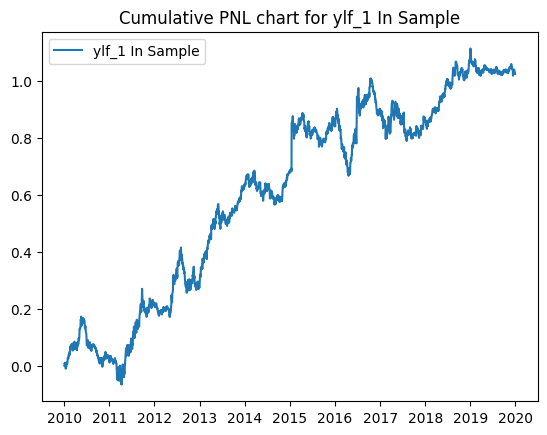

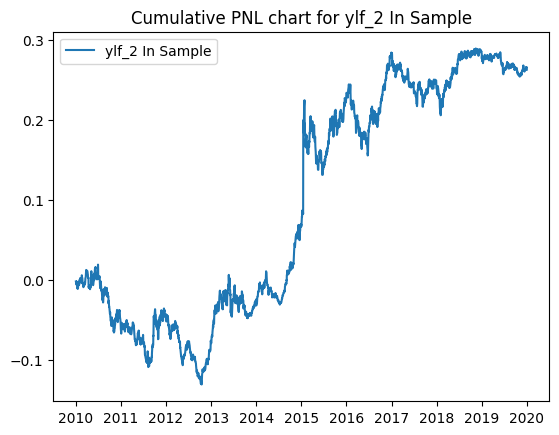

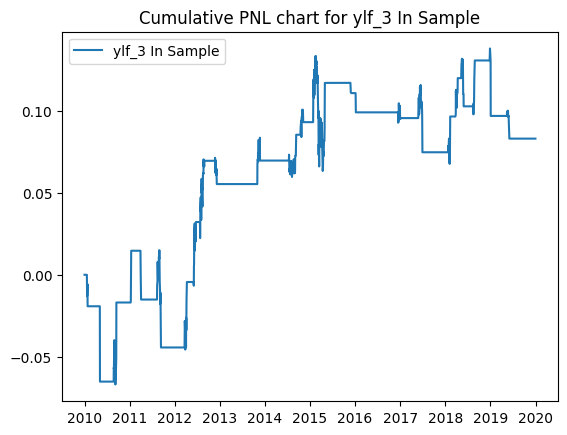

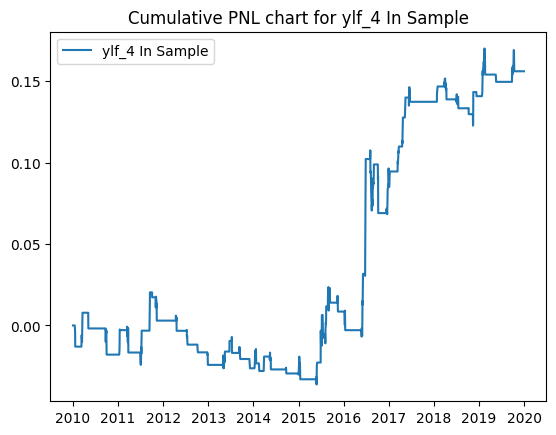

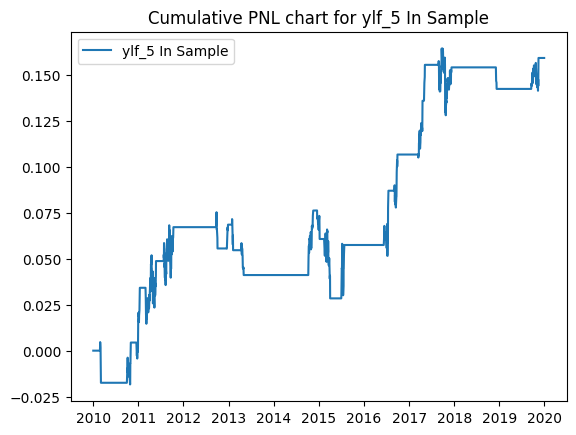

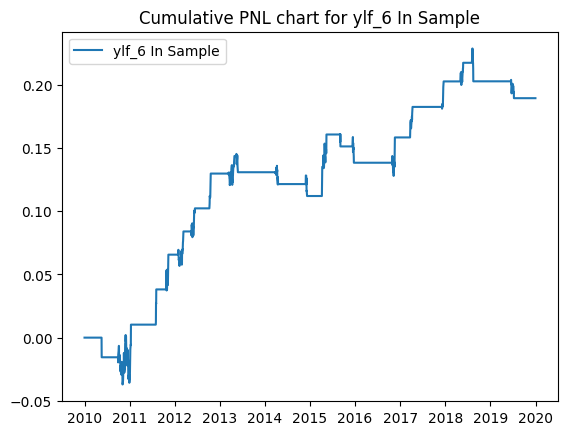

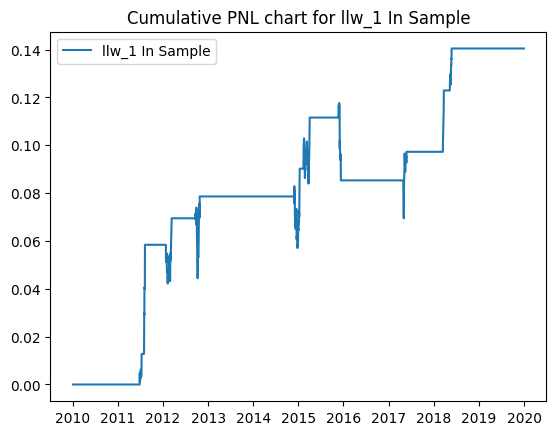

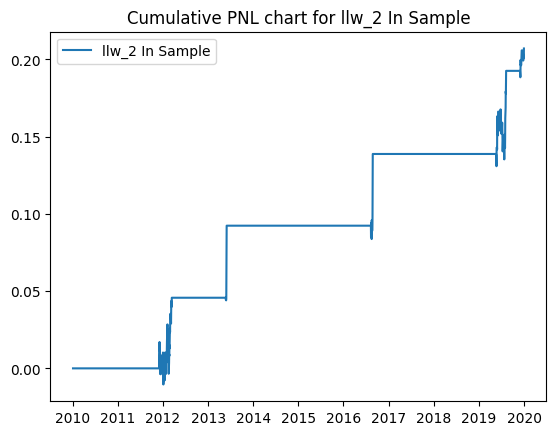

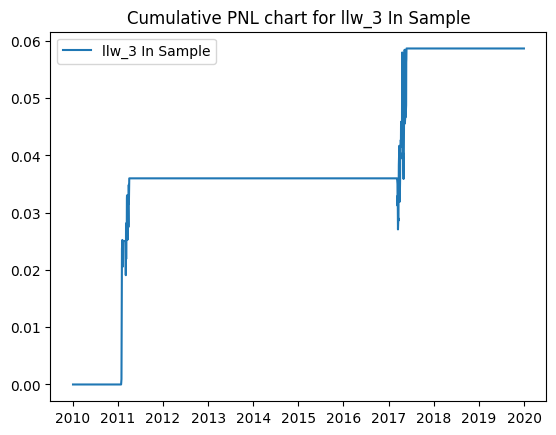

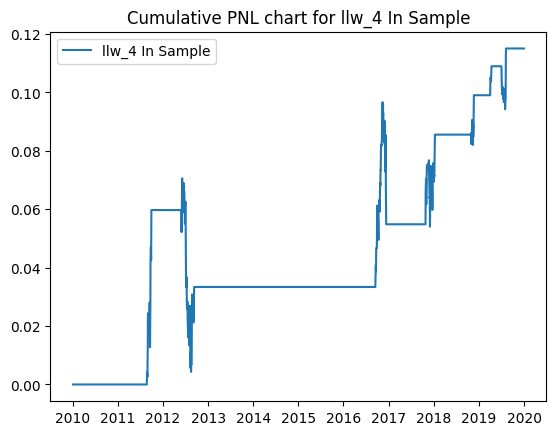

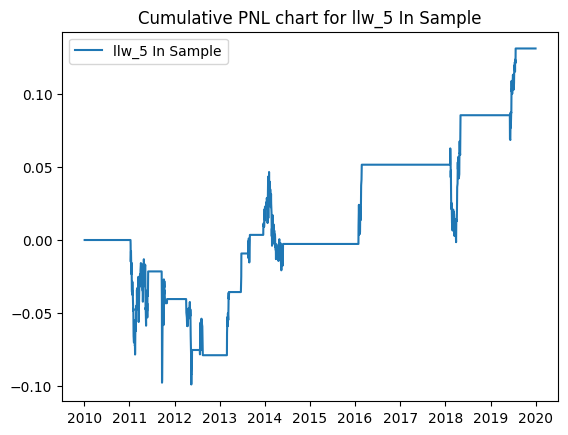

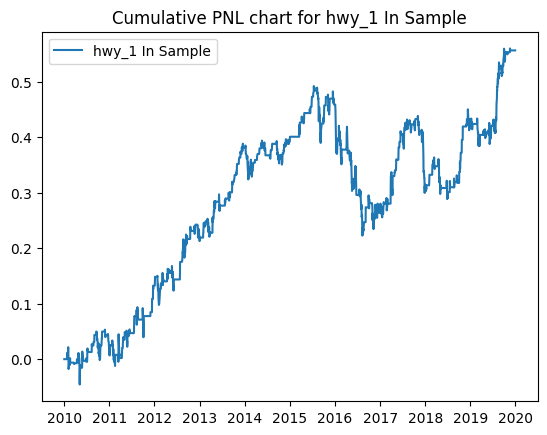

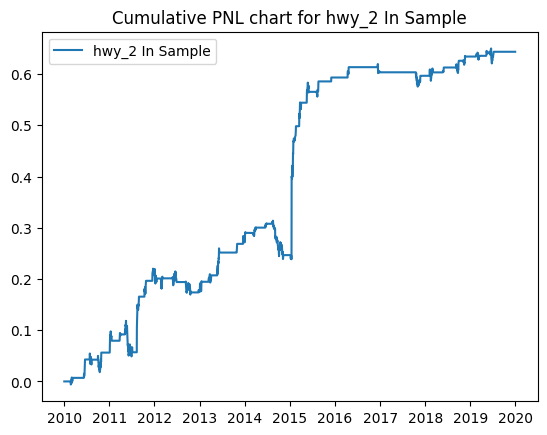

In [26]:
Strategy_performance = []
for col in portfolio_IS.columns:
    Strategy_performance +=\
        [pnlPerformance(portfolio_IS[[col]], f'{col} In Sample')]

In [27]:
Sharpe_IS = []
for metrics in Strategy_performance:
    Sharpe_IS += [metrics.iloc[0,0]]
    print(metrics)
    
Sharpe_IS =\
    pd.DataFrame({"Sharpe_IS":Sharpe_IS})
Sharpe_IS =\
    Sharpe_IS\
    .reset_index()\
    .sort_values(by ='Sharpe_IS',
                 ascending = False)
Sharpe_order =\
    list(Sharpe_IS.iloc[:,0])
print(Sharpe_order)
# portfolio_IS_sort =\
#     portfolio_IS.iloc[:,Sharpe_order]

                                  ylf_1 In Sample PERFORMANCE
Daily annualized sharpe                              0.650196
Average annual returns %                             9.924048
Total returns %                                    102.548493
Max drawdown %                                     -23.849357
%VaR1d 1% - para                                     2.197805
%VaR1d 1% - hist                                     2.365217
%VaR1d 5% - para                                     1.542431
%VaR1d 5% - hist                                     1.383993
Stressed %return during Covid19                      0.000000
Stressed %return during Dec18                        5.148855
Stressed %return during Fall2015                    -2.074963
Stressed %return during Oct14                       -0.538661
Stressed %return during Aug2013                      0.671847
                                  ylf_2 In Sample PERFORMANCE
Daily annualized sharpe                              0.386489
Average 

In [28]:
Sharpe_order

[12, 7, 6, 5, 0, 11, 8, 4, 9, 3, 1, 10, 2]

In [29]:
portfolio_select =\
    portfolio_IS.iloc[:,[Sharpe_order[0]]]
corr_threshold = 0.3
selection_keys = [Sharpe_order[0]]
for i in range(len(Sharpe_order)-1):

    portfolio_select =\
        pd.concat([portfolio_select,
                   portfolio_IS.iloc[:,[Sharpe_order[i+1]]]], 
                  axis = 1)
    if not (abs(portfolio_select.corr().iloc[-1, :-1])\
            < corr_threshold).all():
        
        portfolio_select =\
            portfolio_select.iloc[:,:-1]
        continue
    selection_keys += [Sharpe_order[i+1]]
print(selection_keys)
portfolio_select

[12, 7, 6, 5, 0, 11, 8, 4, 9, 3, 10, 2]


,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
Date,,,,,,,,,,,,
2010-01-01,0.0,NaN,NaN,0.0,-0.000002,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2010-01-04,0.0,-0.000000,-0.0,0.0,0.002798,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
2010-01-05,0.0,0.000000,0.0,0.0,0.007176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.0,0.000000,-0.0,0.0,-0.004365,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
2010-01-07,0.0,0.000000,0.0,0.0,0.004103,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.0,-0.003976,0.0,0.0,-0.002688,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-26,-0.0,0.000510,-0.0,0.0,-0.000634,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
2019-12-27,0.0,0.001725,-0.0,0.0,-0.002287,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0


##### <a id = "p221"> </a> 2.2.1 Manual Selection of Portoflio Strategies [back to table of contents](#top)
* by assigning on `selection_keys`, we may choose certain strategy manually

In [30]:
# selection_keys = [2, 3]
portfolio_select =\
    portfolio_IS.iloc[:,selection_keys]

portfolio_select


,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
Date,,,,,,,,,,,,
2010-01-01,0.0,NaN,NaN,0.0,-0.000002,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2010-01-04,0.0,-0.000000,-0.0,0.0,0.002798,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
2010-01-05,0.0,0.000000,0.0,0.0,0.007176,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-01-06,0.0,0.000000,-0.0,0.0,-0.004365,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
2010-01-07,0.0,0.000000,0.0,0.0,0.004103,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,-0.0,-0.003976,0.0,0.0,-0.002688,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-26,-0.0,0.000510,-0.0,0.0,-0.000634,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0
2019-12-27,0.0,0.001725,-0.0,0.0,-0.002287,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0


In [31]:
portfolio_select.corr()

,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
hwy_2,1.000000,0.004764,-0.001525,0.031333,0.223342,0.033642,-0.009841,-0.021882,0.017088,-0.005739,-0.014629,0.078104
llw_2,0.004764,1.000000,0.020454,0.033722,-0.003882,0.011700,-0.001460,-0.001458,0.013337,0.045011,-0.034454,-0.006255
llw_1,-0.001525,0.020454,1.000000,0.214785,0.038119,-0.000986,0.049539,0.004237,-0.001233,0.005171,0.004628,-0.041079
ylf_6,0.031333,0.033722,0.214785,1.000000,0.047666,0.036794,0.022620,0.049919,-0.001806,-0.001089,-0.000806,0.014161
ylf_1,0.223342,-0.003882,0.038119,0.047666,1.000000,-0.023163,0.047980,-0.016974,-0.076645,0.102653,-0.105796,-0.129571
hwy_1,0.033642,0.011700,-0.000986,0.036794,-0.023163,1.000000,-0.038914,-0.032060,-0.023350,0.050714,-0.008884,0.067025
llw_3,-0.009841,-0.001460,0.049539,0.022620,0.047980,-0.038914,1.000000,0.190664,-0.000894,0.000796,-0.072090,-0.017613
ylf_5,-0.021882,-0.001458,0.004237,0.049919,-0.016974,-0.032060,0.190664,1.000000,0.029829,0.017901,-0.050611,-0.006082
llw_4,0.017088,0.013337,-0.001233,-0.001806,-0.076645,-0.023350,-0.000894,0.029829,1.000000,-0.007358,0.031284,0.076093
ylf_4,-0.005739,0.045011,0.005171,-0.001089,0.102653,0.050714,0.000796,0.017901,-0.007358,1.000000,0.013575,0.001695


In [32]:
portfolio_IS.corr()

,ylf_1,ylf_2,ylf_3,ylf_4,ylf_5,ylf_6,llw_1,llw_2,llw_3,llw_4,llw_5,hwy_1,hwy_2
ylf_1,1.000000,0.472774,-0.129571,0.102653,-0.016974,0.047666,0.038119,-0.003882,0.047980,-0.076645,-0.105796,-0.023163,0.223342
ylf_2,0.472774,1.000000,-0.107063,0.011756,0.024884,0.064669,0.032565,-0.031320,0.000546,0.006860,-0.015578,-0.052687,0.321877
ylf_3,-0.129571,-0.107063,1.000000,0.001695,-0.006082,0.014161,-0.041079,-0.006255,-0.017613,0.076093,0.030400,0.067025,0.078104
ylf_4,0.102653,0.011756,0.001695,1.000000,0.017901,-0.001089,0.005171,0.045011,0.000796,-0.007358,0.013575,0.050714,-0.005739
ylf_5,-0.016974,0.024884,-0.006082,0.017901,1.000000,0.049919,0.004237,-0.001458,0.190664,0.029829,-0.050611,-0.032060,-0.021882
ylf_6,0.047666,0.064669,0.014161,-0.001089,0.049919,1.000000,0.214785,0.033722,0.022620,-0.001806,-0.000806,0.036794,0.031333
llw_1,0.038119,0.032565,-0.041079,0.005171,0.004237,0.214785,1.000000,0.020454,0.049539,-0.001233,0.004628,-0.000986,-0.001525
llw_2,-0.003882,-0.031320,-0.006255,0.045011,-0.001458,0.033722,0.020454,1.000000,-0.001460,0.013337,-0.034454,0.011700,0.004764
llw_3,0.047980,0.000546,-0.017613,0.000796,0.190664,0.022620,0.049539,-0.001460,1.000000,-0.000894,-0.072090,-0.038914,-0.009841
llw_4,-0.076645,0.006860,0.076093,-0.007358,0.029829,-0.001806,-0.001233,0.013337,-0.000894,1.000000,0.031284,-0.023350,0.017088


In [33]:
portfolio_select.mean()/portfolio_select.std()

hwy_2    0.055820
llw_2    0.048365
llw_1    0.041613
ylf_6    0.041083
ylf_1    0.040951
hwy_1    0.036476
llw_3    0.030183
ylf_5    0.030131
llw_4    0.029612
ylf_4    0.028676
llw_5    0.016080
ylf_3    0.011361
dtype: float64

In [34]:
portfolio_Sharpe = []
VaR_IS = []

for i in range(len(selection_keys)):
    portfolio_Sharpe +=\
    [
        Strategy_performance[selection_keys[i]]\
        .iloc[0,0]
    ]
    VaR_IS +=\
    [
        Strategy_performance[selection_keys[i]]\
        .iloc[5,0]             
    ]
print(portfolio_Sharpe)
print(VaR_IS)

[0.886291758800584, 0.7679185817630637, 0.6607177925723472, 0.652298049885101, 0.650196243475231, 0.5791421178948127, 0.4792336934166637, 0.4784113403225419, 0.47016753308278486, 0.45529786436371594, 0.2553087388918093, 0.18038189738214255]
[0.9162671773183759, 0.45032544782196277, 0.4196583092017453, 0.5943375223309448, 2.365217329023182, 1.7532928293603725, 0.0925018278282236, 0.6796401230786616, 0.5310616051907161, 0.5973791609304793, 1.0292241166993372, 0.9449342095625739]


In [35]:
strategy_equal_w = []
strategy_Sharpe_w = []
strategy_vol_w = []

# lenth of nomination_w depends on the lenth of selection_keys
strategy_nomination_w = [0.3, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01] # just an example
strategy_nomination_w =\
    strategy_nomination_w[:len(selection_keys)] # just an example
vol_IS = portfolio_select.std()*np.sqrt(252)
inv_Vol_IS = 1/vol_IS

for i in range(len(portfolio_Sharpe)):
    strategy_equal_w += [1/len(portfolio_Sharpe)]
    strategy_Sharpe_w += [portfolio_Sharpe[i]/sum(portfolio_Sharpe)]
    strategy_vol_w += [inv_Vol_IS[i]/sum(inv_Vol_IS)]
portfolio_w =\
    pd.DataFrame(
    {           
        'Equal weight': strategy_equal_w,        
        'Sharpe adjusted': strategy_Sharpe_w,     
        'Risk adjusted': strategy_vol_w,         
        'Nomination weight': strategy_nomination_w,
        'Strategy Sharpe': portfolio_Sharpe,               
    },
    index = portfolio_select.columns
    )
print(portfolio_w.iloc[:,:-1].sum())
portfolio_w

Equal weight         1.00
Sharpe adjusted      1.00
Risk adjusted        1.00
Nomination weight    0.84
dtype: float64


,Equal weight,Sharpe adjusted,Risk adjusted,Nomination weight,Strategy Sharpe
hwy_2,0.083333,0.136031,0.037028,0.30,0.886292
llw_2,0.083333,0.117863,0.099651,0.10,0.767919
llw_1,0.083333,0.101409,0.126403,0.10,0.660718
ylf_6,0.083333,0.100117,0.092545,0.10,0.652298
ylf_1,0.083333,0.099794,0.017047,0.05,0.650196
hwy_1,0.083333,0.088889,0.027990,0.05,0.579142
llw_3,0.083333,0.073554,0.219477,0.05,0.479234
ylf_5,0.083333,0.073428,0.080708,0.05,0.478411
llw_4,0.083333,0.072163,0.109854,0.01,0.470168
ylf_4,0.083333,0.069881,0.078417,0.01,0.455298


In [36]:
selection_keys

[12, 7, 6, 5, 0, 11, 8, 4, 9, 3, 10, 2]

In [37]:
portfolio_select_OS =\
    portfolio_OS.iloc[:,selection_keys]

portfolio_select_OS

,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
Date,,,,,,,,,,,,
2020-01-01,-0.000000,-0.0,-0.0,-0.0,-0.016641,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000
2020-01-02,0.000000,0.0,-0.0,0.0,0.017782,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-03,0.000000,0.0,0.0,0.0,0.008999,0.005362,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-06,0.000000,0.0,0.0,0.0,0.012213,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-07,-0.000000,0.0,0.0,0.0,-0.007924,-0.000000,0.0,0.000000,-0.0,0.000000,-0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.001477,0.0,0.0,0.0,-0.001018,0.000000,0.0,0.002314,0.0,-0.001229,0.0,0.000420
2024-02-27,0.001532,0.0,0.0,0.0,0.003262,-0.000000,0.0,-0.000732,-0.0,0.001908,-0.0,-0.003297
2024-02-28,0.001250,-0.0,0.0,0.0,-0.000181,-0.000000,-0.0,0.000139,0.0,-0.000336,0.0,0.001036


In [38]:
strategy_w = []
for weights in portfolio_w.columns[:-1]:
#     print(portfolio_w[weights])
    strategy_temp_w =\
        pd.DataFrame(index=portfolio_select_OS.index, 
                     columns = portfolio_select_OS.columns) 
    strategy_temp_w.iloc[:] =\
        portfolio_w[weights]
    strategy_w += [strategy_temp_w]
    
for s_w in strategy_w:
    print(s_w.tail(3))

               hwy_2     llw_2     llw_1     ylf_6     ylf_1     hwy_1  \
Date                                                                     
2024-02-28  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333   
2024-02-29  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333   
2024-03-01  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333   

               llw_3     ylf_5     llw_4     ylf_4     llw_5     ylf_3  
Date                                                                    
2024-02-28  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333  
2024-02-29  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333  
2024-03-01  0.083333  0.083333  0.083333  0.083333  0.083333  0.083333  
               hwy_2     llw_2     llw_1     ylf_6     ylf_1     hwy_1  \
Date                                                                     
2024-02-28  0.136031  0.117863  0.101409  0.100117  0.099794  0.088889   
2024-02-29  0.136031  0.117863  0.101409  

In [39]:
my_portfolio =\
    pd.DataFrame(index=portfolio_select_OS.index,
                 columns = portfolio_w.columns[:-1])

for i in range(len(strategy_w)):
    temp_p =\
        (strategy_w[i] *\
        portfolio_select_OS)\
        .sum(axis =1)
    my_portfolio.iloc[:,i] = temp_p 
my_portfolio

,Equal weight,Sharpe adjusted,Risk adjusted,Nomination weight
Date,,,,
2020-01-01,-0.001387,-0.001661,-0.000284,-0.000832
2020-01-02,0.001482,0.001775,0.000303,0.000889
2020-01-03,0.001197,0.001375,0.000303,0.000718
2020-01-06,0.001018,0.001219,0.000208,0.000611
2020-01-07,-0.00066,-0.000791,-0.000135,-0.000396
...,...,...,...,...
2024-02-26,-0.000083,-0.000207,0.000043,-0.000387
2024-02-27,0.000223,0.000522,0.00001,0.000572
2024-02-28,0.000159,0.000167,0.000089,0.00038


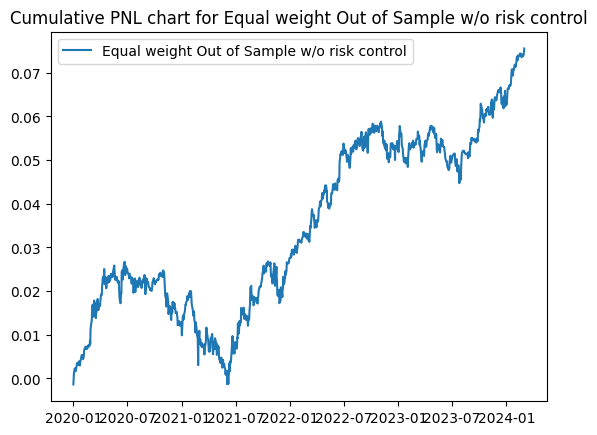

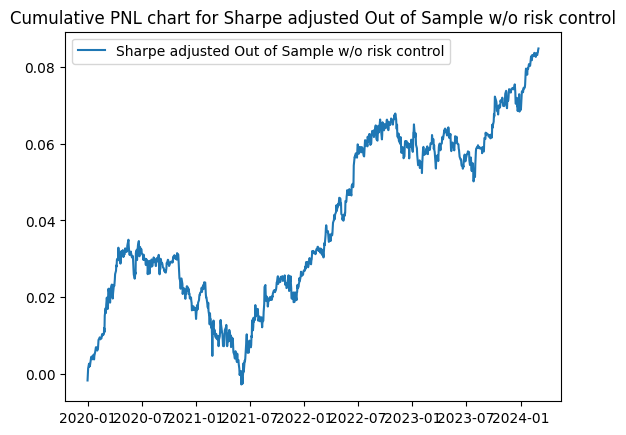

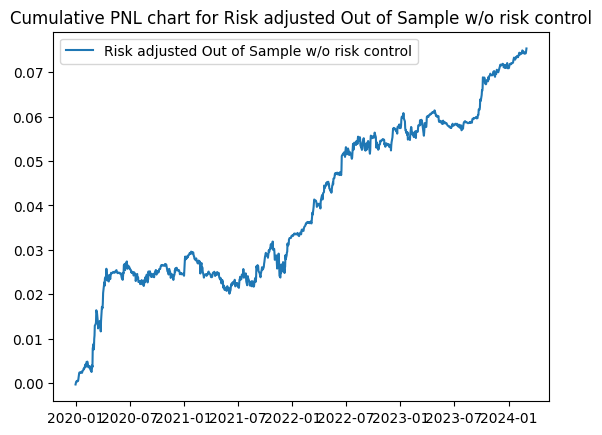

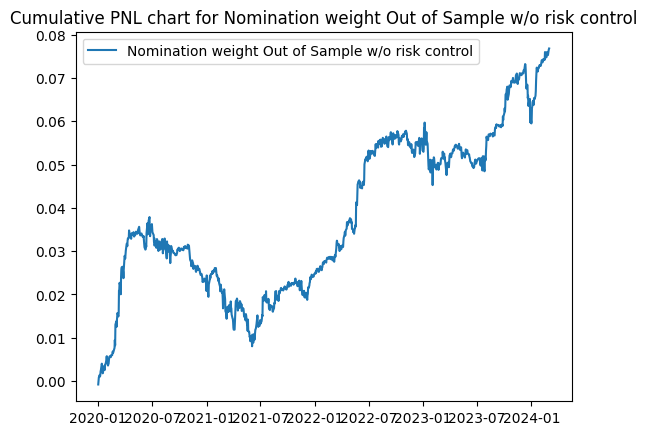

In [40]:
my_portfolio_performance = []
for col in my_portfolio.columns:
    my_portfolio_performance +=\
        [pnlPerformance(my_portfolio[[col]], f'{col} Out of Sample w/o risk control')]

In [41]:
for perf in my_portfolio_performance:
    print(perf)

                                  Equal weight Out of Sample w/o risk control PERFORMANCE
Daily annualized sharpe                                                    0.979486      
Average annual returns %                                                   1.750384      
Total returns %                                                            7.557213      
Max drawdown %                                                            -2.805051      
%VaR1d 1% - para                                                           0.255059      
%VaR1d 1% - hist                                                           0.299292      
%VaR1d 5% - para                                                           0.178306      
%VaR1d 5% - hist                                                           0.180690      
Stressed %return during Covid19                                            0.247957      
Stressed %return during Dec18                                              0.000000      
Stressed %

##### <a id = "p23"> </a> 2.3 Final Portfolio [back to table of contents](#top)

In [42]:
VaR_IS

[0.9162671773183759,
 0.45032544782196277,
 0.4196583092017453,
 0.5943375223309448,
 2.365217329023182,
 1.7532928293603725,
 0.0925018278282236,
 0.6796401230786616,
 0.5310616051907161,
 0.5973791609304793,
 1.0292241166993372,
 0.9449342095625739]

In [43]:
def risk_control(pnl_df, threshold, rebalance_idx, weight_df, strike=2):
    pnl = pnl_df.copy()
    col = pnl.columns[0]
    
    w_rm = weight_df.copy()
    
    rebalance_idx = pd.to_datetime(rebalance_idx)
#     pnl.index =\
#         pnl.index.strftime('%Y-%m-%d')

    pnl[f'{col}_rm'] = pnl[col]
    
    risk_management = 0
    current_strike = 0
    for idx in pnl.index:
        if pnl.loc[idx,col] < -threshold:
            current_strike += 1
#             print('1st strike: ', idx)
            if current_strike >= strike:
                print(f"{strike}-strike control: ", idx)

                current_strike = 0
                risk_management += 1
                clear_start =\
                    pnl.index[pnl.index.get_loc(idx)+1]
                
                for re_idx in rebalance_idx:
                    
                    clear_end = re_idx
                    if clear_end > clear_start:
                        print(clear_start,clear_end)
                        break
                print(f"risk control No. {risk_management} for {col}")
                print(f"from {clear_start} to {clear_end}")
                pnl.loc[clear_start:clear_end, f'{col}_rm'] = 0
                w_rm.loc[clear_start:clear_end] = 0
            continue
        current_strike = 0
    if risk_management==0:
        print(f"no violation under {strike}-strike condition for {col}")
    pnl.cumsum().plot()
    plt.title('PnL cum sum')
    return pnl, w_rm

In [44]:
portfolio_select_OS

,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
Date,,,,,,,,,,,,
2020-01-01,-0.000000,-0.0,-0.0,-0.0,-0.016641,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.0,-0.000000
2020-01-02,0.000000,0.0,-0.0,0.0,0.017782,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-03,0.000000,0.0,0.0,0.0,0.008999,0.005362,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-06,0.000000,0.0,0.0,0.0,0.012213,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2020-01-07,-0.000000,0.0,0.0,0.0,-0.007924,-0.000000,0.0,0.000000,-0.0,0.000000,-0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.001477,0.0,0.0,0.0,-0.001018,0.000000,0.0,0.002314,0.0,-0.001229,0.0,0.000420
2024-02-27,0.001532,0.0,0.0,0.0,0.003262,-0.000000,0.0,-0.000732,-0.0,0.001908,-0.0,-0.003297
2024-02-28,0.001250,-0.0,0.0,0.0,-0.000181,-0.000000,-0.0,0.000139,0.0,-0.000336,0.0,0.001036


In [45]:
selection_keys

[12, 7, 6, 5, 0, 11, 8, 4, 9, 3, 10, 2]

In [46]:
sig_dates_corrected = {}

for i,j in enumerate(selection_keys):
    sig_dates_corrected[i] = sig_dates[j]

2-strike control:  2023-02-02 00:00:00
2023-02-03 00:00:00 2023-02-06 00:00:00
risk control No. 1 for hwy_2
from 2023-02-03 00:00:00 to 2023-02-06 00:00:00
2-strike control:  2020-02-12 00:00:00
2020-02-13 00:00:00 2020-03-09 00:00:00
risk control No. 1 for llw_2
from 2020-02-13 00:00:00 to 2020-03-09 00:00:00
2-strike control:  2020-04-08 00:00:00
2020-04-09 00:00:00 2020-04-15 00:00:00
risk control No. 2 for llw_2
from 2020-04-09 00:00:00 to 2020-04-15 00:00:00
2-strike control:  2023-01-17 00:00:00
2023-01-18 00:00:00 2023-04-03 00:00:00
risk control No. 3 for llw_2
from 2023-01-18 00:00:00 to 2023-04-03 00:00:00
2-strike control:  2023-03-20 00:00:00
2023-03-21 00:00:00 2023-04-03 00:00:00
risk control No. 4 for llw_2
from 2023-03-21 00:00:00 to 2023-04-03 00:00:00
2-strike control:  2021-05-03 00:00:00
2021-05-04 00:00:00 2021-12-17 00:00:00
risk control No. 1 for llw_1
from 2021-05-04 00:00:00 to 2021-12-17 00:00:00
2-strike control:  2021-07-22 00:00:00
2021-07-23 00:00:00 2021-

,hwy_2,llw_2,llw_1,ylf_6,ylf_1,hwy_1,llw_3,ylf_5,llw_4,ylf_4,llw_5,ylf_3
Date,,,,,,,,,,,,
2020-01-01,-0.000000,-0.0,-0.0,-0.0,-0.016641,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2020-01-02,0.000000,0.0,-0.0,0.0,0.017782,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.000000,0.0,0.0,0.0,0.008999,0.005362,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.000000,0.0,0.0,0.0,0.012213,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,-0.000000,0.0,0.0,0.0,-0.007924,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,-0.001477,0.0,0.0,0.0,-0.001018,0.0,0.0,0.002314,0.0,-0.001229,0.0,0.00042
2024-02-27,0.001532,0.0,0.0,0.0,0.003262,-0.0,0.0,-0.000732,-0.0,0.001908,-0.0,-0.003297
2024-02-28,0.001250,-0.0,0.0,0.0,-0.000181,-0.0,-0.0,0.000139,0.0,-0.000336,0.0,0.001036


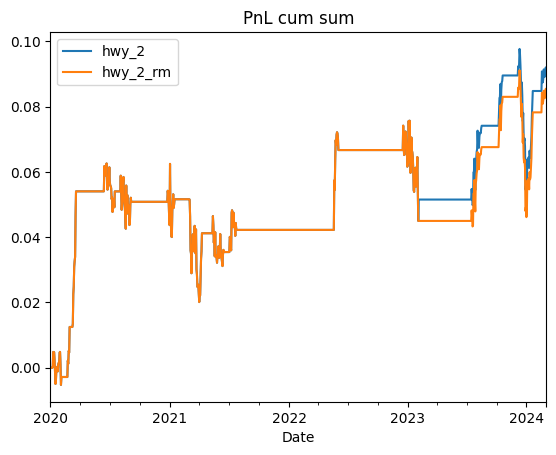

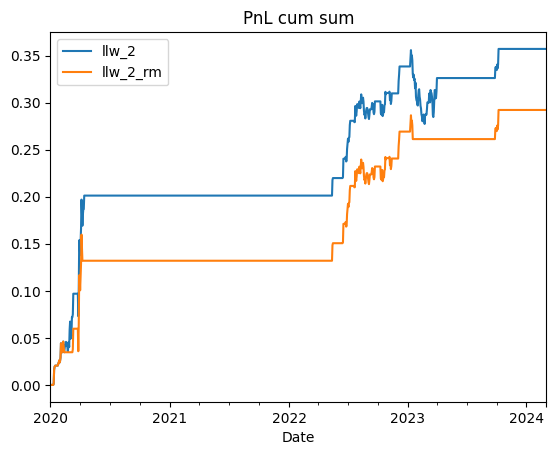

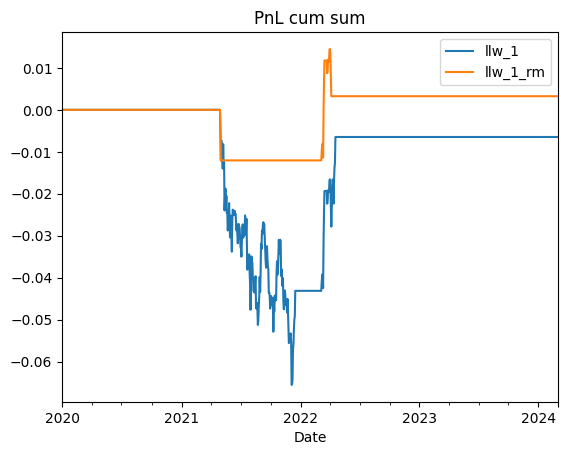

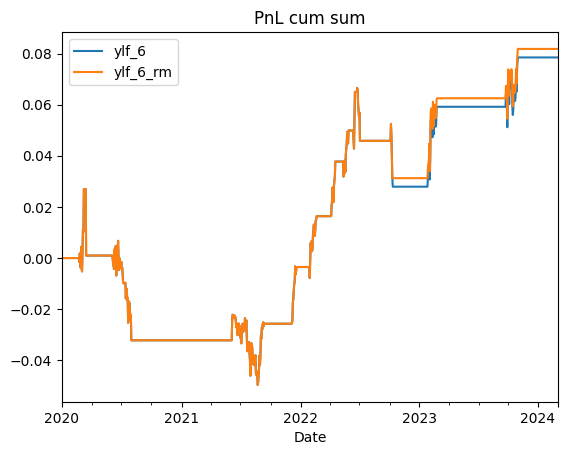

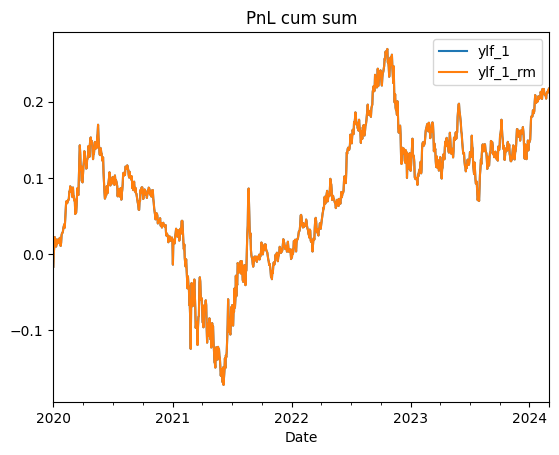

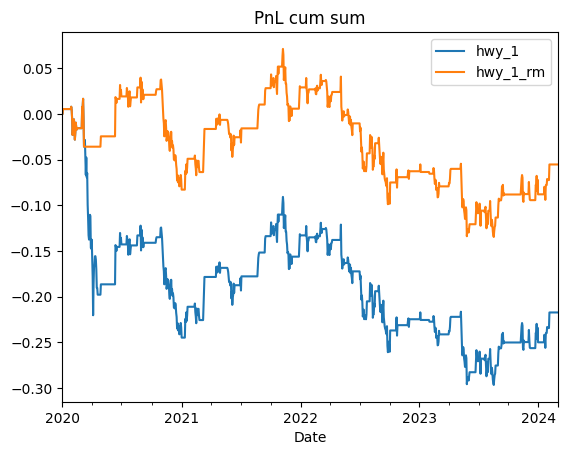

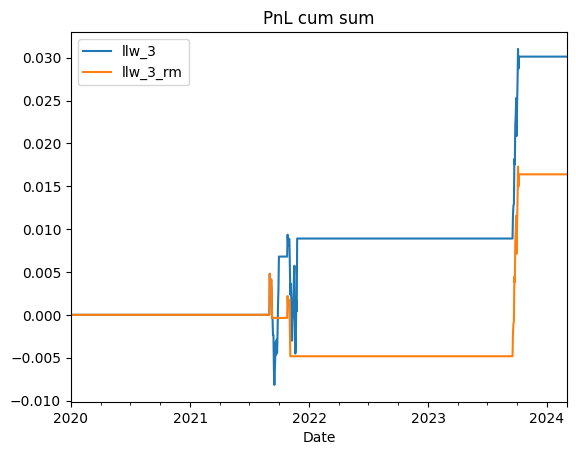

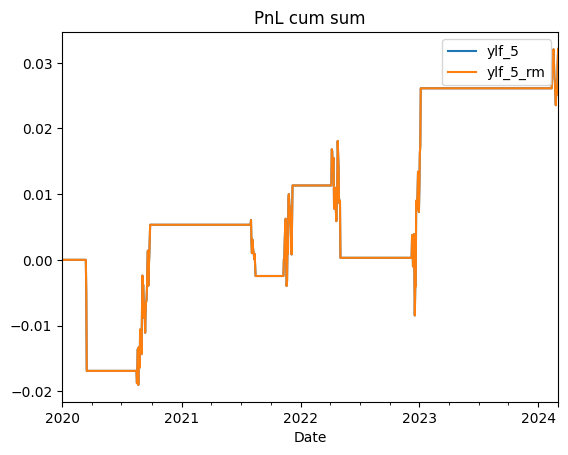

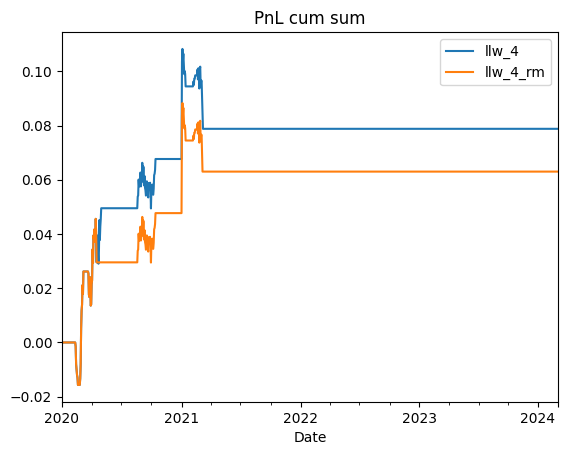

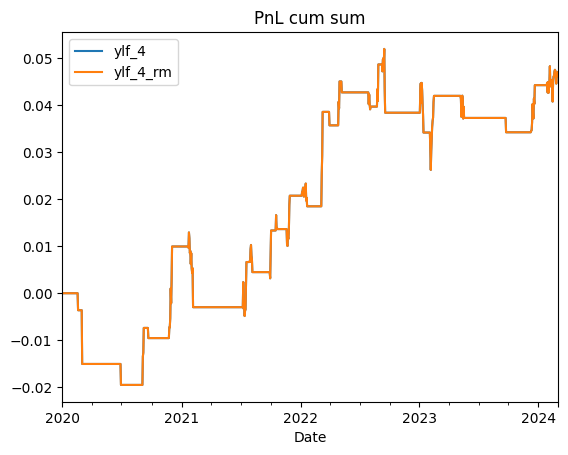

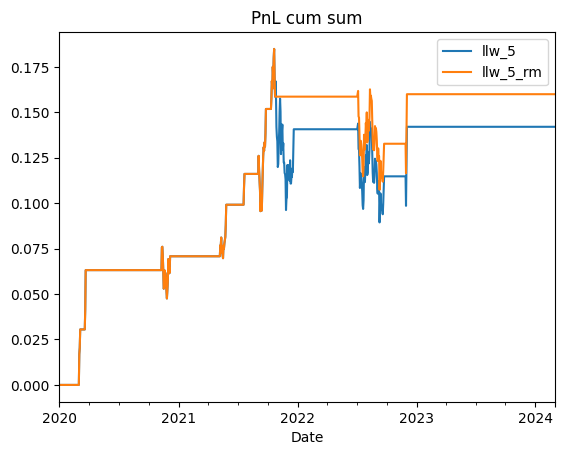

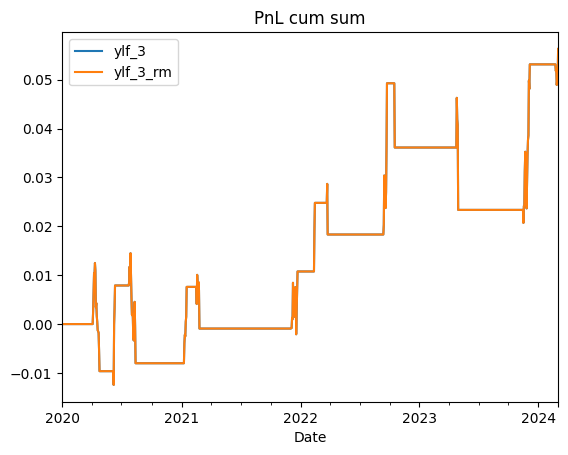

In [47]:
portfolio_select_OS_2strike =\
    pd.DataFrame(index = portfolio_select_OS.index,
                 columns = portfolio_select_OS.columns)
portfolio_weightage_OS_2strike = []
for i in range(portfolio_select_OS.shape[1]):
    temp_p, temp_w =\
        risk_control(portfolio_select_OS.iloc[:,[i]], 
                     VaR_IS[i]/100, sig_dates_corrected[i], 
                     strategy_w_dict[selection_keys[i]].loc[end:], 2)

    portfolio_select_OS_2strike.iloc[:,i] =\
        temp_p.iloc[:,[-1]]
    portfolio_weightage_OS_2strike += [temp_w]

portfolio_select_OS_2strike

##### <a id = "p24"> </a> 2.4 Visualization [back to table of contents](#top)

In [48]:
my_portfolio_2strike =\
    pd.DataFrame(index=portfolio_select_OS_2strike.index,
                 columns = portfolio_w.columns[:-1])

for i in range(len(strategy_w)):
    temp_p =\
        (strategy_w[i] *\
        portfolio_select_OS_2strike)\
        .sum(axis =1)
    my_portfolio_2strike.iloc[:,i] = temp_p 
my_portfolio_2strike

,Equal weight,Sharpe adjusted,Risk adjusted,Nomination weight
Date,,,,
2020-01-01,-0.001387,-0.001661,-0.000284,-0.000832
2020-01-02,0.001482,0.001775,0.000303,0.000889
2020-01-03,0.001197,0.001375,0.000303,0.000718
2020-01-06,0.001018,0.001219,0.000208,0.000611
2020-01-07,-0.00066,-0.000791,-0.000135,-0.000396
...,...,...,...,...
2024-02-26,-0.000083,-0.000207,0.000043,-0.000387
2024-02-27,0.000223,0.000522,0.00001,0.000572
2024-02-28,0.000159,0.000167,0.000089,0.00038


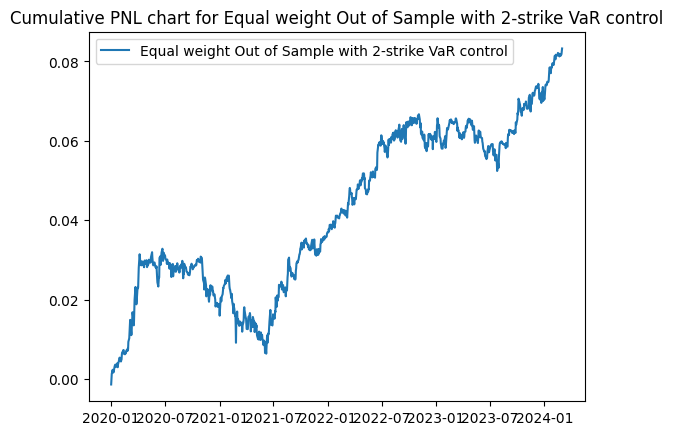

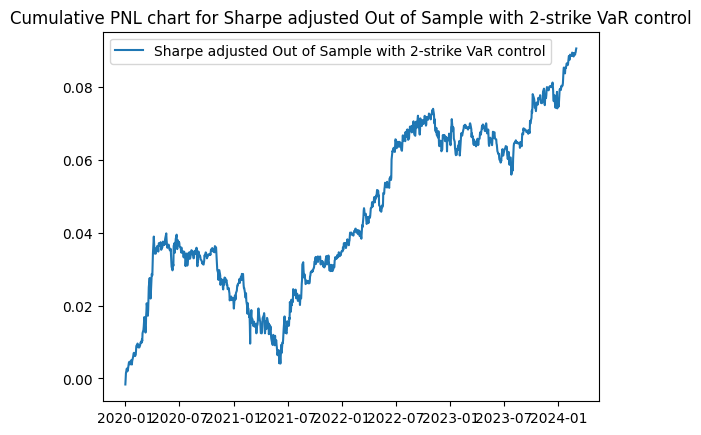

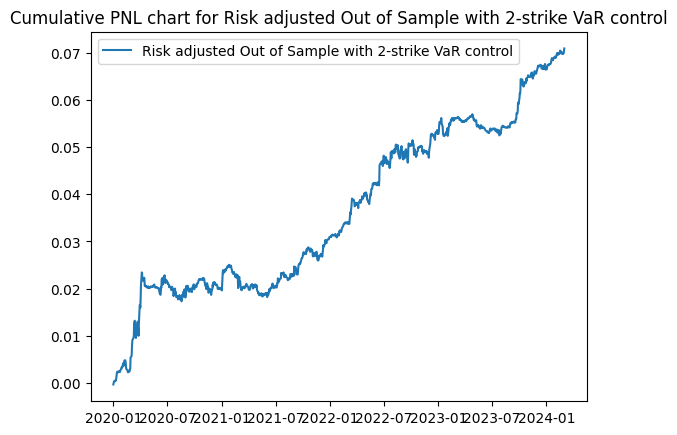

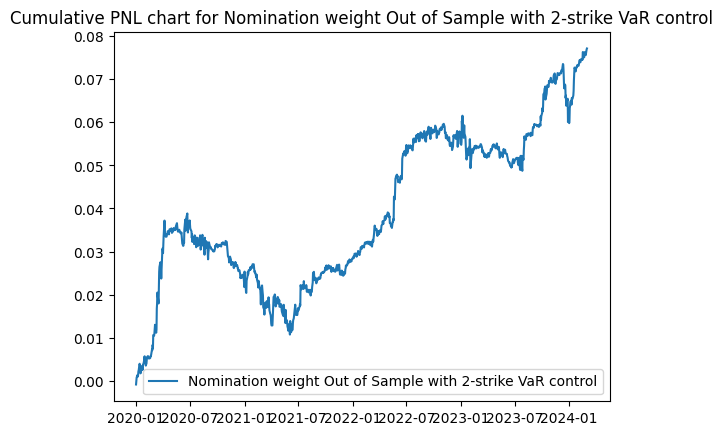

In [49]:
my_portfolio_2strike_perform = []
for col in my_portfolio_2strike.columns:
    my_portfolio_2strike_perform +=\
        [pnlPerformance(my_portfolio_2strike[[col]],
                        f'{col} Out of Sample with 2-strike VaR control')]

In [50]:
for perf in my_portfolio_2strike_perform:
    print(perf)

                                  Equal weight Out of Sample with 2-strike VaR control PERFORMANCE
Daily annualized sharpe                                                    1.102058               
Average annual returns %                                                   1.928202               
Total returns %                                                            8.324936               
Max drawdown %                                                            -2.642975               
%VaR1d 1% - para                                                           0.248869               
%VaR1d 1% - hist                                                           0.274199               
%VaR1d 5% - para                                                           0.173722               
%VaR1d 5% - hist                                                           0.169162               
Stressed %return during Covid19                                            0.414853               
Stressed %

In [51]:
portfolio_select_OS.mean()/portfolio_select_OS.std()*np.sqrt(252)


hwy_2    0.567636
llw_2    1.373512
llw_1   -0.063441
ylf_6    0.500141
ylf_1    0.327778
hwy_1   -0.474119
llw_3    0.665247
ylf_5    0.387175
llw_4    0.613919
ylf_4    0.567330
llw_5    0.616236
ylf_3    0.520620
dtype: float64

In [52]:
portfolio_w

,Equal weight,Sharpe adjusted,Risk adjusted,Nomination weight,Strategy Sharpe
hwy_2,0.083333,0.136031,0.037028,0.30,0.886292
llw_2,0.083333,0.117863,0.099651,0.10,0.767919
llw_1,0.083333,0.101409,0.126403,0.10,0.660718
ylf_6,0.083333,0.100117,0.092545,0.10,0.652298
ylf_1,0.083333,0.099794,0.017047,0.05,0.650196
hwy_1,0.083333,0.088889,0.027990,0.05,0.579142
llw_3,0.083333,0.073554,0.219477,0.05,0.479234
ylf_5,0.083333,0.073428,0.080708,0.05,0.478411
llw_4,0.083333,0.072163,0.109854,0.01,0.470168
ylf_4,0.083333,0.069881,0.078417,0.01,0.455298


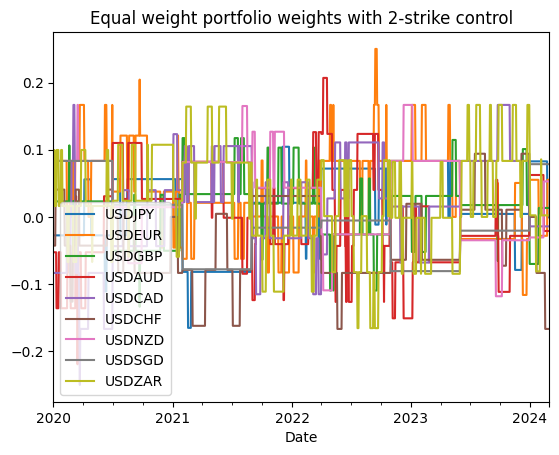

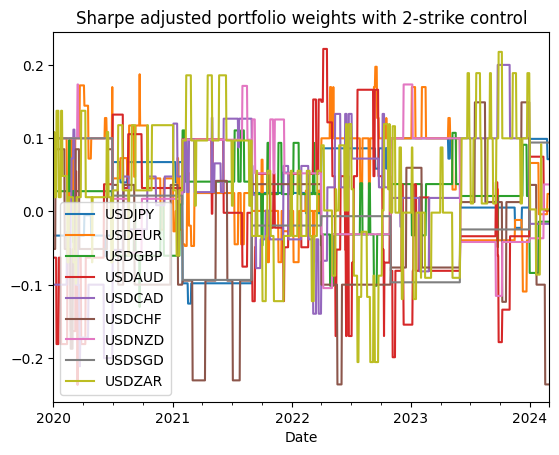

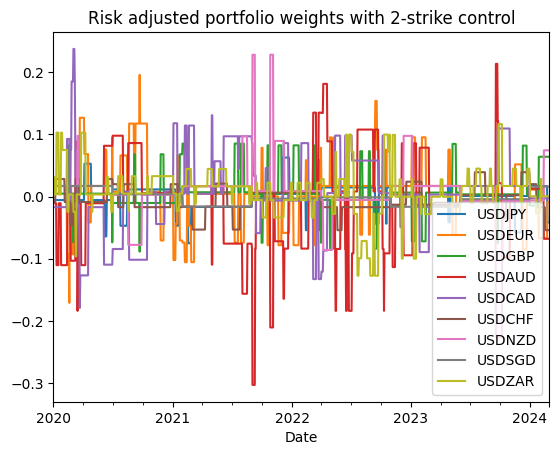

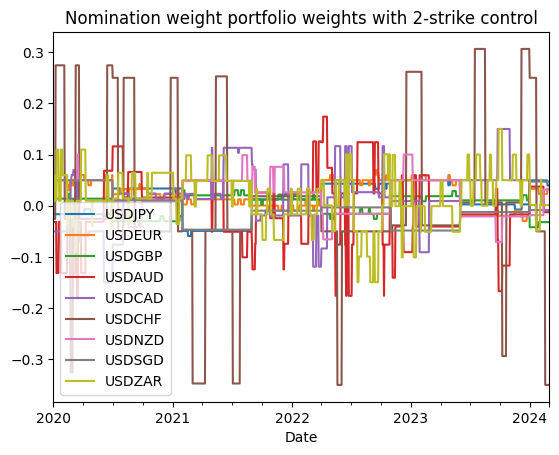

In [53]:
my_portfolio_2strike_w = []

for i in range(portfolio_w.shape[1]-1):
    weighted_sum_df = pd.DataFrame()
    weightage_list = list(portfolio_w.iloc[:,i])
    
    for df, weight in zip(portfolio_weightage_OS_2strike, weightage_list):
        weighted_df = df * weight
        if weighted_sum_df.empty:
            weighted_sum_df = weighted_df
        else:
            weighted_sum_df += weighted_df   
            
    weighted_sum_df.plot()
    plt.title(f'{portfolio_w.columns[i]} portfolio weights with 2-strike control')
    my_portfolio_2strike_w += [weighted_sum_df]

In [54]:
# my_portfolio_2strike_w = []

# for i in range(portfolio_w.shape[1]-1):
#     weighted_sum_df = pd.DataFrame()
#     weightage_list = list(portfolio_w.iloc[:,i])
    
#     for df, weight in zip(portfolio_weightage_OS_2strike, weightage_list):
#         weighted_df = df * weight
#         if weighted_sum_df.empty:
#             weighted_sum_df = weighted_df
#         else:
#             weighted_sum_df += weighted_df   
            
#     weighted_sum_df.loc['2020-07-01':'2020-10-15'].plot()
#     plt.title(f'{portfolio_w.columns[i]} portfolio weights with 2-strike control')
#     my_portfolio_2strike_w += [weighted_sum_df]

In [55]:
for w in my_portfolio_2strike_w:
    print(w.head())

              USDJPY    USDEUR    USDGBP   USDAUD    USDCAD    USDCHF  \
Date                                                                    
2020-01-01 -0.027434  0.083333  0.023122 -0.05258 -0.083333 -0.042711   
2020-01-02 -0.027434  0.083333  0.023122 -0.05258 -0.083333 -0.042711   
2020-01-03 -0.027434  0.083333  0.023122 -0.05258 -0.083333 -0.042711   
2020-01-06 -0.027434  0.083333  0.023122 -0.05258 -0.083333 -0.042711   
2020-01-07 -0.027434  0.083333  0.023122 -0.05258 -0.083333 -0.042711   

              USDNZD    USDSGD    USDZAR  
Date                                      
2020-01-01  0.083333  0.083333  0.016270  
2020-01-02  0.083333  0.083333  0.016270  
2020-01-03  0.083333  0.083333  0.099603  
2020-01-06  0.083333  0.083333  0.016270  
2020-01-07  0.083333  0.083333  0.016270  
              USDJPY    USDEUR   USDGBP    USDAUD    USDCAD    USDCHF  \
Date                                                                    
2020-01-01 -0.032853  0.099794  0.02769 -

In [56]:
portfolio_weightage_OS_2strike

[            USDJPY  USDEUR  USDGBP  USDAUD  USDCAD  USDCHF  USDNZD  USDSGD  \
 Date                                                                         
 2020-01-01       0       0       0       0       0     0.0       0       0   
 2020-01-02       0       0       0       0       0     0.0       0       0   
 2020-01-03       0       0       0       0       0     0.0       0       0   
 2020-01-06       0       0       0       0       0     0.0       0       0   
 2020-01-07       0       0       0       0       0     0.0       0       0   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 2024-02-23       0       0       0       0       0    -1.0       0       0   
 2024-02-26       0       0       0       0       0    -1.0       0       0   
 2024-02-27       0       0       0       0       0    -1.0       0       0   
 2024-02-28       0       0       0       0       0    -1.0       0       0   
 2024-02-29       0       0       0       0       0 